In [3]:
import os
import gc
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from decimal import ROUND_HALF_UP, Decimal
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [4]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error
from lightgbm import LGBMRegressor

### Local

%%time
financials_df = pd.read_csv("train_files/financials.csv")
options_df = pd.read_csv("train_files/options.csv")
secondary_stock_prices_df = pd.read_csv("train_files/secondary_stock_prices.csv")
stock_prices_df = pd.read_csv("train_files/stock_prices.csv")
trades_df = pd.read_csv("train_files/trades.csv")
stocks_df = pd.read_csv("stock_list.csv")

### Kaggle

In [135]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

**Datasets**

In [5]:
%%time
#financials_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv")
#options_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")
#secondary_stock_prices_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv")
stock_prices_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
trades_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
stocks_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")

CPU times: user 8.27 s, sys: 533 ms, total: 8.8 s
Wall time: 10.6 s


**Suplemental files**

In [3]:
financials_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/financials.csv")
options_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/options.csv")
secondary_stock_prices_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/secondary_stock_prices.csv")
stock_prices_info = pd.read_csv("//kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/secondary_stock_prices.csv")
trades_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/trades.csv")
stocks_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")

## 0. Utils

To understand how Target is calculated

In [137]:
def target(df):
    df_temp = df.copy()
    df_temp["Close_shift1"] = df_temp["Close"].shift(-1)
    df_temp["Close_shift2"] = df_temp["Close"].shift(-2)
    df_temp["Target"] = (df_temp["Close_shift2"] - df_temp["Close_shift1"]) / df_temp["Close_shift1"]
    return df_temp

In [138]:
def ranked(df):
    df["rank"] = df["Target"].rank(ascending=False,method="first") -1 
    df = df.sort_values("rank").reset_index(drop=True)
    return df

In [139]:
def daily_top200(df):
    tmpdf2_top200 = df.iloc[:200,:]
    tmpdf2_top200
    
    return df

In [140]:
def daily_bottom200(df):
    return df

In [4]:
def plot_candle_with_target(df_prices, stock_code, prime=True):
    """Plot OHLCV plot with target series.
    
    Parameters:
        stock_code: int, code of the stock
        prime: bool, whether the stock to plot is prime or not
    """
    df_ = df_prices.copy() if prime else df_prices_sec.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    dates = df_['Date'].values
    ohlc = {
        'open': df_['Open'].values, 
        'high': df_['High'].values, 
        'low': df_['Low'].values, 
        'close': df_['Close'].values
    }
    vol = df_['Volume'].values
    target = df_['Target'].values
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
    fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc),
                  row=1, col=1)
    fig.add_trace(go.Bar(x=dates, y=vol, name='Volume'),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=dates, y=target, name='Target'),
                  row=3, col=1)
    fig.update_layout(
        title=f"OHLCV Chart with Target Series (Stock {stock_code})",
    )
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

In [142]:
def plot_candle_with_target_adjusted(df_prices, stock_code, prime=True):
    """Plot OHLCV plot with target series.
    
    Parameters:
        stock_code: int, code of the stock
        prime: bool, whether the stock to plot is prime or not
    """
    df_ = df_prices.copy() if prime else df_prices_sec.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    dates = df_['Date'].values
    ohlc = {
        'open': df_['AdjustedOpen'].values, 
        'high': df_['AdjustedHigh'].values, 
        'low': df_['AdjustedLow'].values, 
        'close': df_['AdjustedClose'].values
    }
    vol = df_['Volume'].values
    target = df_['Target'].values
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
    fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc),
                  row=1, col=1)
    fig.add_trace(go.Bar(x=dates, y=vol, name='Volume'),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=dates, y=target, name='Target'),
                  row=3, col=1)
    fig.update_layout(
        title=f"OHLCV Chart with Target Series (Stock {stock_code})",
    )
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

### Evaluation function

In [6]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

**Adjust Split-Reverse/split price**

In [7]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        
        
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        )) 

        # generate AdjustedOpen
        df.loc[:, "AdjustedOpen"] = (
            df["CumulativeAdjustmentFactor"] * df["Open"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        
        # generate AdjustedHigh
        df.loc[:, "AdjustedHigh"] = (
            df["CumulativeAdjustmentFactor"] * df["High"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        
        # generate Low
        df.loc[:, "AdjustedLow"] = (
            df["CumulativeAdjustmentFactor"] * df["Low"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        
        
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
       
        #df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].interpolate(method='linear',limit_direction='backward')
        df.loc[:, "AdjustedOpen"] = df.loc[:, "AdjustedOpen"].interpolate(method='linear',limit_direction='backward')
        df.loc[:, "AdjustedHigh"] = df.loc[:, "AdjustedHigh"].interpolate(method='linear',limit_direction='backward')
        df.loc[:, "AdjustedLow"] = df.loc[:, "AdjustedLow"].interpolate(method='linear',limit_direction='backward')

        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)
    price.drop(columns=['Open', 'High','Low','Close','AdjustmentFactor'],inplace =True)
    #price.set_index("Date", inplace=True)
    return price

## 1. Exploratory Data Analysis

### Stock prices
stock_prices.csv

File Description
The core file of interest, including the daily closing price for each stock and the target column. Following is column information recorded in stock_price_spec.csv:

    RowId: Unique ID of price records, the combination of Date and SecuritiesCode.
    Date: Trade date.
    SecuritiesCode: Local securities code.
    Open: First traded price on a day.
    High: Highest traded price on a day.
    Low: Lowest traded price on a day.
    Close: Last traded price on a day.
    Volume: Number of traded stocks on a day.
    AdjustmentFactor: Used to calculate theoretical price/volume when split/reverse-split happens (NOT including dividend/allotment of shares).
    ExpectedDividend: Expected dividend value for ex-right date. This value is recorded 2 business days before ex-dividend date.
    SupervisionFlag: Flag of securities under supervision and securities to be delisted, for more information, please see here.
    Target: Change ratio of adjusted closing price between t+2 and t+1 where t+0 is trade date.

In [145]:
display(stock_prices_df.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [146]:
stock_prices_df.shape

(2332531, 12)

In [147]:
stock_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [148]:
stock_prices_df.describe()

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,2.332531e+06,2.324923e+06,2.324923e+06,2.324923e+06,2.324923e+06,2.332531e+06,2.332531e+06,18865.000000,2.332293e+06
mean,5.894835e+03,2.594511e+03,2.626540e+03,2.561227e+03,2.594023e+03,6.919366e+05,1.000508e+00,22.017730,4.450962e-04
std,2.404161e+03,3.577192e+03,3.619363e+03,3.533494e+03,3.576538e+03,3.911256e+06,6.773040e-02,29.882453,2.339879e-02
min,1.301000e+03,1.400000e+01,1.500000e+01,1.300000e+01,1.400000e+01,0.000000e+00,1.000000e-01,0.000000,-5.785414e-01
25%,3.891000e+03,1.022000e+03,1.035000e+03,1.009000e+03,1.022000e+03,3.030000e+04,1.000000e+00,5.000000,-1.049869e-02
50%,6.238000e+03,1.812000e+03,1.834000e+03,1.790000e+03,1.811000e+03,1.071000e+05,1.000000e+00,15.000000,0.000000e+00
75%,7.965000e+03,3.030000e+03,3.070000e+03,2.995000e+03,3.030000e+03,4.021000e+05,1.000000e+00,30.000000,1.053159e-02
max,9.997000e+03,1.099500e+05,1.105000e+05,1.072000e+05,1.095500e+05,6.436540e+08,2.000000e+01,1070.000000,1.119512e+00


**Missing values**

In [149]:
display(pd.isna(stock_prices_df).sum()/len(stock_prices_df)*100)

RowId                0.000000
Date                 0.000000
SecuritiesCode       0.000000
Open                 0.326169
High                 0.326169
Low                  0.326169
Close                0.326169
Volume               0.000000
AdjustmentFactor     0.000000
ExpectedDividend    99.191222
SupervisionFlag      0.000000
Target               0.010204
dtype: float64

In [150]:
missing_high = stock_prices_df[stock_prices_df["High"].isna()]

In [151]:
display(missing_high.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
401,20170104_3540,2017-01-04,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
1753,20170104_9539,2017-01-04,9539,NaN,NaN,NaN,NaN,0,1.0,NaN,False,-0.004149
2266,20170105_3540,2017-01-05,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
2511,20170105_4621,2017-01-05,4621,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000
4131,20170106_3540,2017-01-06,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN


In [152]:
display(missing_high.shape[0])

7608

In [153]:
missing_high["Date"].nunique()

1175

In [154]:
missing_high["Date"].value_counts()

2020-10-01    1988
2017-03-16      15
2019-10-09      14
2019-04-04      14
2021-10-29      13
              ... 
2017-12-25       1
2017-12-26       1
2020-03-13       1
2018-01-04       1
2018-02-21       1
Name: Date, Length: 1175, dtype: int64

In [155]:
plot_missing_high_df = missing_high["Date"].value_counts().to_frame().reset_index()
plot_missing_high_df.rename(columns = {'index':'Date', 'Date':'Count'}, inplace = True)
plot_missing_high_df.head()

,Date,Count
0,2020-10-01,1988
1,2017-03-16,15
2,2019-10-09,14
3,2019-04-04,14
4,2021-10-29,13


2020-10-01 is the day with the most amount of missing data

In [156]:
plot_missing_high_df["Date"] = pd.to_datetime(plot_missing_high_df["Date"])
plot_missing_high_df.sort_values(by="Date",inplace=True)

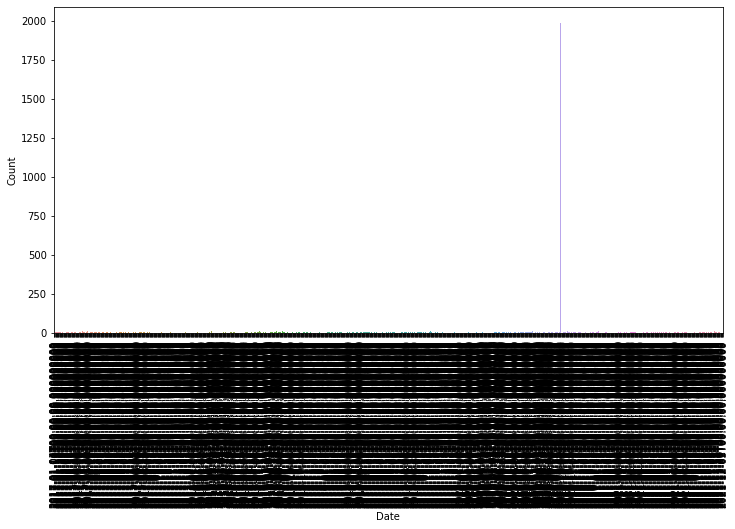

In [157]:

ax = plt.subplots(figsize = (12,6))    
ax= sns.barplot(x = "Date", y = "Count", data = plot_missing_high_df)
ax.tick_params(axis='x', rotation=90)


In [158]:
missing_Target = stock_prices_df[stock_prices_df["Target"].isna()]

In [159]:
display(missing_Target.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
401,20170104_3540,2017-01-04,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
2266,20170105_3540,2017-01-05,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
4131,20170106_3540,2017-01-06,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
5996,20170110_3540,2017-01-10,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
7861,20170111_3540,2017-01-11,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN


In [160]:
display(missing_Target.shape[0])

238

In [161]:
missing_Target["Date"].nunique()

238

In [162]:
missing_Target["Date"].value_counts()

2017-01-04    1
2017-08-30    1
2017-08-14    1
2017-08-15    1
2017-08-16    1
             ..
2017-05-08    1
2017-05-09    1
2017-05-10    1
2017-05-11    1
2020-10-02    1
Name: Date, Length: 238, dtype: int64

In [163]:
plot_missing_target_df = missing_Target["Date"].value_counts().to_frame().reset_index()
plot_missing_target_df.rename(columns = {'index':'Date', 'Date':'Count'}, inplace = True)
plot_missing_target_df

,Date,Count
0,2017-01-04,1
1,2017-08-30,1
2,2017-08-14,1
3,2017-08-15,1
4,2017-08-16,1
...,...,...
233,2017-05-08,1
234,2017-05-09,1
235,2017-05-10,1
236,2017-05-11,1


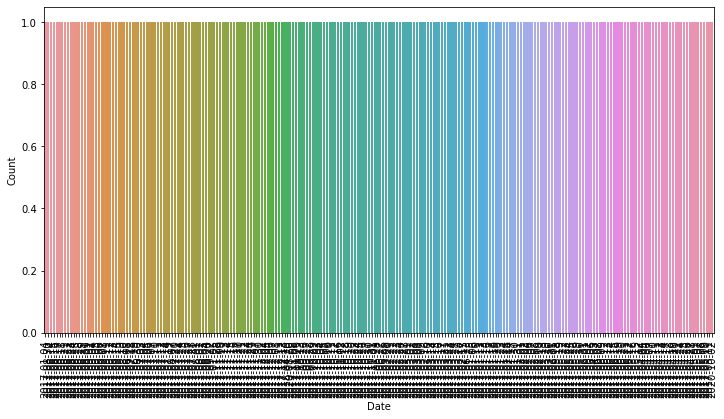

In [164]:
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x = "Date", y = "Count", data = plot_missing_target_df, ax=ax)
ax.tick_params(axis='x', rotation=90)

Add analysis about the value of Target attribute

### Stocks

stock_list.csv


SecuritiesCode: Local securities code.
    EffectiveDate: The effective date. (Need clarification.)
    Name: Name of security.
    Section/Products: Section/Product.

    NewMarketSegment: New market segment effective from 2022-04-04 (as of 15:30 JST on Mar 11 2022). For more information, please see Overview of Market Restructuring.
    33SectorCode: 33 sector code.
    33SectorName: 33 sector name.
    17SectorCode: 17 sector code.
    17SectorName: 17 sector name.
　
 For more information about sector code and name, please see TOPIX Sector Indices / TOPIX-17 Series

    NewIndexSeriesSizeCode: TOPIX New Index Series code.
    NewIndexSeriesSize: TOPIX New Index Series name.
For more information about TOPIX New Index Series code and name, please see TOPIX New Index Series / Size-based TOPIX.

    TradeDate: Trade date to calculate MarketCapitalization.
    Close: Close price to calculate MarketCapitalization.
    IssuedShares: Issued shares.
    MarketCapitalization: Market capitalization on December 3, 2021.
    Universe0: A flag of prediction target universe (top 2000 stocks by market capitalization).

In [165]:
display(stocks_df.head(5))

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,1.092828e+07,3.365911e+10,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False
2,1306,20211230,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2073.5,7.917718e+09,1.641739e+13,False
3,1308,20211230,Nikko Exchange Traded Index Fund TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2053.0,3.736943e+09,7.671945e+12,False
4,1309,20211230,NEXT FUNDS ChinaAMC SSE50 Index Exchange Trade...,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,44280.0,7.263200e+04,3.216145e+09,False


In [166]:
stocks_df.shape

(4417, 16)

In [167]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SecuritiesCode          4417 non-null   int64  
 1   EffectiveDate           4417 non-null   int64  
 2   Name                    4417 non-null   object 
 3   Section/Products        4417 non-null   object 
 4   NewMarketSegment        3772 non-null   object 
 5   33SectorCode            4417 non-null   object 
 6   33SectorName            4417 non-null   object 
 7   17SectorCode            4417 non-null   object 
 8   17SectorName            4417 non-null   object 
 9   NewIndexSeriesSizeCode  4417 non-null   object 
 10  NewIndexSeriesSize      4417 non-null   object 
 11  TradeDate               4121 non-null   float64
 12  Close                   4121 non-null   float64
 13  IssuedShares            4121 non-null   float64
 14  MarketCapitalization    4121 non-null   

In [168]:
display(pd.isna(stocks_df).sum()/len(stocks_df)*100)

SecuritiesCode             0.000000
EffectiveDate              0.000000
Name                       0.000000
Section/Products           0.000000
NewMarketSegment          14.602671
33SectorCode               0.000000
33SectorName               0.000000
17SectorCode               0.000000
17SectorName               0.000000
NewIndexSeriesSizeCode     0.000000
NewIndexSeriesSize         0.000000
TradeDate                  6.701381
Close                      6.701381
IssuedShares               6.701381
MarketCapitalization       6.701381
Universe0                  0.000000
dtype: float64

In [169]:
stocks_missing_Date = stocks_df[stocks_df["TradeDate"].isna()]
stocks_missing_Date.head()

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
62,1408,20000101,"ITbook Co.,LTD.",Mothers (Domestic),NaN,-,-,-,-,-,-,NaN,NaN,NaN,NaN,False
164,1606,20000101,"Japan Drilling Co.,Ltd.",First Section (Domestic),NaN,1050,Mining,2,ENERGY RESOURCES,-,-,NaN,NaN,NaN,NaN,False
231,1722,20000101,"MISAWA HOMES CO.,LTD.",First Section (Domestic),NaN,2050,Construction,3,CONSTRUCTION & MATERIALS,-,-,NaN,NaN,NaN,NaN,False
235,1728,20000101,"MISAWA HOMES CHUGOKU CO.,LTD.",JASDAQ(Standard / Domestic),NaN,-,-,-,-,-,-,NaN,NaN,NaN,NaN,False
252,1782,20000101,"Joban Kaihatsu Co.,Ltd.",JASDAQ(Standard / Domestic),NaN,-,-,-,-,-,-,NaN,NaN,NaN,NaN,False


In [170]:
stocks_missing_segment = stocks_df[stocks_df["NewMarketSegment"].isna()]
stocks_missing_segment.head()

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False
2,1306,20211230,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2073.5,7.917718e+09,1.641739e+13,False
3,1308,20211230,Nikko Exchange Traded Index Fund TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2053.0,3.736943e+09,7.671945e+12,False
4,1309,20211230,NEXT FUNDS ChinaAMC SSE50 Index Exchange Trade...,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,44280.0,7.263200e+04,3.216145e+09,False
5,1311,20211230,NEXT FUNDS TOPIX Core 30 Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,1025.0,1.926421e+06,1.974582e+09,False


In [171]:
stocks_df["Universe0"].value_counts()

False    2417
True     2000
Name: Universe0, dtype: int64

In [172]:
stocks_df["33SectorName"].value_counts()

Information & Communication                      551
Services                                         521
-                                                500
Retail Trade                                     359
Wholesale Trade                                  320
Electric Appliances                              255
Machinery                                        230
Chemicals                                        218
Construction                                     170
Real Estate                                      143
Foods                                            125
Other Products                                   116
Transportation Equipment                          95
Banks                                             93
Metal Products                                    90
Pharmaceutical                                    77
Land Transportation                               62
Glass and Ceramics Products                       56
Textiles and Apparels                         

In [173]:
sector = stocks_df["33SectorName"].value_counts().to_frame()
sector.reset_index(inplace=True)
sector["percentage"] = sector["33SectorName"]/sector["33SectorName"].sum()*100
sector.head(5)

,index,33SectorName,percentage
0,Information & Communication,551,12.474530
1,Services,521,11.795336
2,-,500,11.319900
3,Retail Trade,359,8.127688
4,Wholesale Trade,320,7.244736


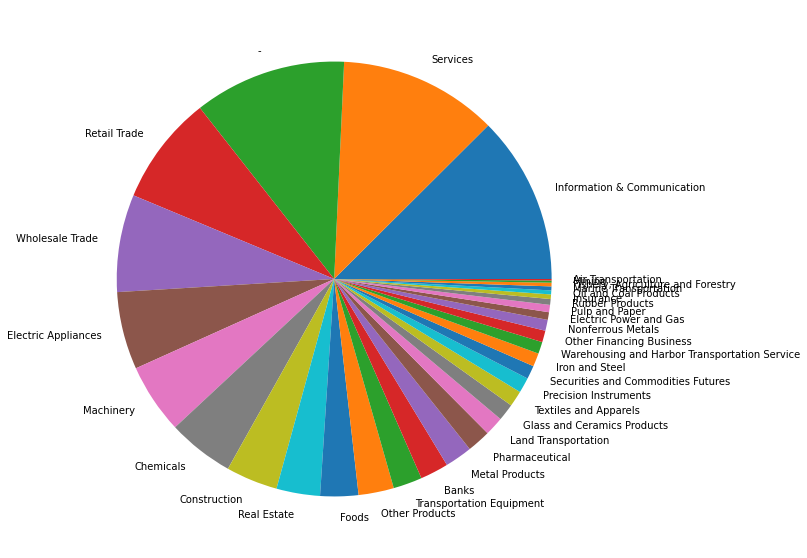

In [174]:
plt.rcParams["figure.figsize"] = (30,10)
plt.pie(sector["percentage"], labels = sector["index"])
plt.show()

In [175]:
stocks_df["Section/Products"].value_counts()

First Section (Domestic)                                       2327
JASDAQ(Standard / Domestic)                                     726
Second Section(Domestic)                                        530
Mothers (Domestic)                                              439
ETFs/ ETNs                                                      277
REIT, Venture Funds, Country Funds and Infrastructure Funds      68
JASDAQ(Growth/Domestic)                                          41
First Section (Foreign)                                           4
Mothers (Foreign)                                                 3
JASDAQ(Standard / Foreign)                                        1
Second Section(Foreign)                                           1
Name: Section/Products, dtype: int64

In [176]:
section = stocks_df["Section/Products"].value_counts().to_frame()
section.reset_index(inplace=True)
section["percentage"] = section["Section/Products"]/section["Section/Products"].sum()*100
section

,index,Section/Products,percentage
0,First Section (Domestic),2327,52.682816
1,JASDAQ(Standard / Domestic),726,16.436495
2,Second Section(Domestic),530,11.999094
3,Mothers (Domestic),439,9.938873
4,ETFs/ ETNs,277,6.271225
5,"REIT, Venture Funds, Country Funds and Infrast...",68,1.539506
6,JASDAQ(Growth/Domestic),41,0.928232
7,First Section (Foreign),4,0.090559
8,Mothers (Foreign),3,0.067919
9,JASDAQ(Standard / Foreign),1,0.022640


In [177]:
section["percentage"] = section["Section/Products"]/section["Section/Products"].sum()*100

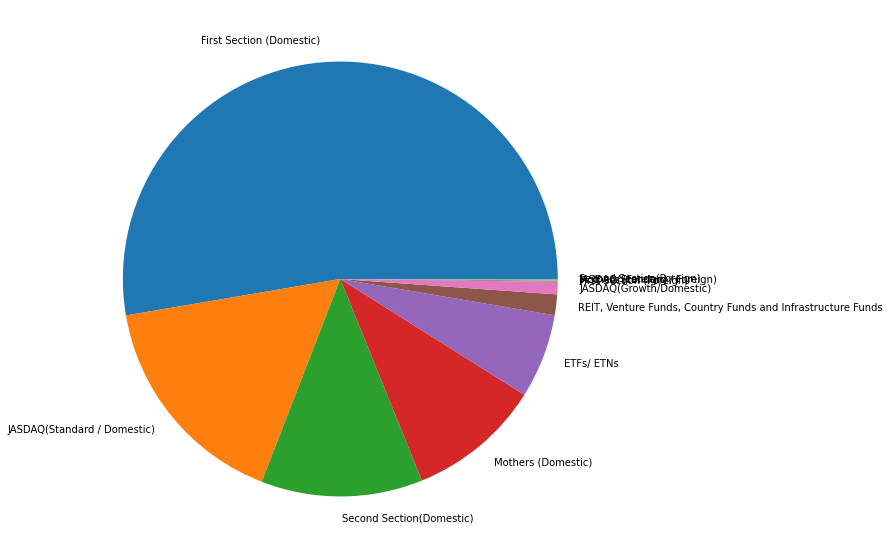

In [178]:
plt.rcParams["figure.figsize"] = (30,10)
plt.pie(section["percentage"], labels = section["index"])
plt.show()

## Selecting the top 2000 Stocks (Universe0 Flag = True)

In [8]:
stocks2000_df = stocks_df[stocks_df["Universe0"]]
stocks2000_df

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,10928283.0,3.365911e+10,True
19,1332,20211230,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,20211230.0,543.0,312430277.0,1.696496e+11,True
20,1333,20211230,Maruha Nichiro Corporation,First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,20211230.0,2405.0,52656910.0,1.266399e+11,True
37,1375,20211230,"YUKIGUNI MAITAKE CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,6,TOPIX Small 1,20211230.0,1196.0,39910700.0,4.773320e+10,True
38,1376,20211230,"KANEKO SEEDS CO.,LTD.",First Section (Domestic),Standard Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,1504.0,11772626.0,1.770603e+10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4408,9990,20211230,SAC'S BAR HOLDINGS INC.,First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,20211230.0,518.0,29859900.0,1.546743e+10,True
4409,9991,20211230,GECOSS CORPORATION,First Section (Domestic),Prime Market,6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,7,TOPIX Small 2,20211230.0,825.0,36436125.0,3.005980e+10,True
4411,9993,20211230,"YAMAZAWA CO.,LTD.",First Section (Domestic),Standard Market,6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,20211230.0,1626.0,10960825.0,1.782230e+10,True
4412,9994,20211230,YAMAYA CORPORATION,First Section (Domestic),Standard Market,6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,20211230.0,2447.0,10847870.0,2.654474e+10,True


In [180]:
stocks2000_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 4415
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SecuritiesCode          2000 non-null   int64  
 1   EffectiveDate           2000 non-null   int64  
 2   Name                    2000 non-null   object 
 3   Section/Products        2000 non-null   object 
 4   NewMarketSegment        2000 non-null   object 
 5   33SectorCode            2000 non-null   object 
 6   33SectorName            2000 non-null   object 
 7   17SectorCode            2000 non-null   object 
 8   17SectorName            2000 non-null   object 
 9   NewIndexSeriesSizeCode  2000 non-null   object 
 10  NewIndexSeriesSize      2000 non-null   object 
 11  TradeDate               2000 non-null   float64
 12  Close                   2000 non-null   float64
 13  IssuedShares            2000 non-null   float64
 14  MarketCapitalization    2000 non-null   

In [181]:
stocks2000_df["33SectorName"].value_counts()

Information & Communication                      229
Services                                         201
Retail Trade                                     179
Electric Appliances                              156
Wholesale Trade                                  151
Chemicals                                        142
Machinery                                        128
Construction                                      91
Foods                                             86
Real Estate                                       69
Banks                                             64
Transportation Equipment                          51
Pharmaceutical                                    47
Other Products                                    47
Land Transportation                               44
Metal Products                                    36
Precision Instruments                             33
Glass and Ceramics Products                       30
Other Financing Business                      

In [182]:
sector2000 = stocks2000_df["33SectorName"].value_counts().to_frame()
sector2000.reset_index(inplace=True)
sector2000["percentage"] = sector2000["33SectorName"]/sector2000["33SectorName"].sum()*100
sector2000.head(5)

,index,33SectorName,percentage
0,Information & Communication,229,11.45
1,Services,201,10.05
2,Retail Trade,179,8.95
3,Electric Appliances,156,7.80
4,Wholesale Trade,151,7.55


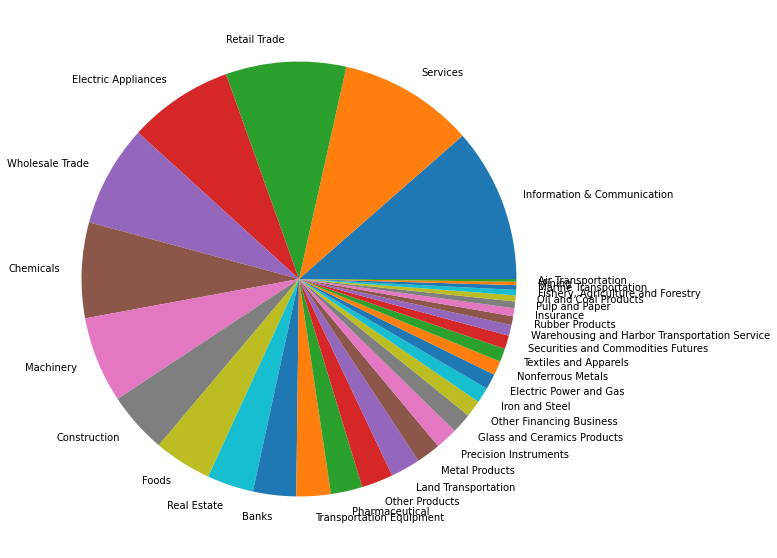

In [183]:
plt.rcParams["figure.figsize"] = (40,10)
plt.pie(sector2000["percentage"], labels = sector2000["index"])
plt.show()

In [184]:
section2000 = stocks2000_df["Section/Products"].value_counts().to_frame()
section2000.reset_index(inplace=True)
section2000["percentage"] = section2000["Section/Products"]/section2000["Section/Products"].sum()*100
section2000

,index,Section/Products,percentage
0,First Section (Domestic),1711,85.55
1,JASDAQ(Standard / Domestic),107,5.35
2,Second Section(Domestic),90,4.50
3,Mothers (Domestic),85,4.25
4,JASDAQ(Growth/Domestic),7,0.35


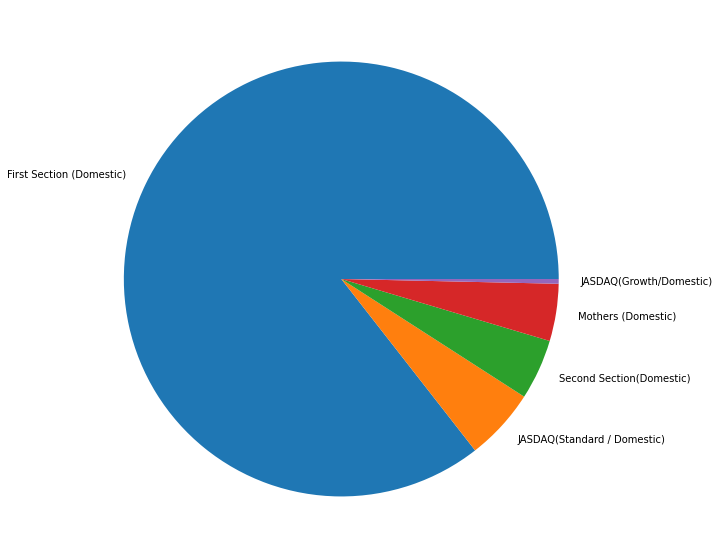

In [185]:
plt.rcParams["figure.figsize"] = (30,10)
plt.pie(section2000["percentage"], labels = section2000["index"])
plt.show()

## Merging Stock metadate with stock price

In [9]:
col = ["SecuritiesCode","Name","Section/Products","NewMarketSegment","33SectorCode","33SectorName","17SectorCode","17SectorName","NewIndexSeriesSizeCode","NewIndexSeriesSize","IssuedShares","MarketCapitalization"]
df_prices = pd.merge(stock_prices_df, stocks2000_df[col], on='SecuritiesCode')
df_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10


**Free memory**

In [63]:
del stock_prices_df
del stocks2000_df

gc.collect()

516

**Calculating Target variable statistics**

In [187]:
mean_securities_df = df_prices.groupby(["SecuritiesCode"])["Target"].mean()
total_mean_securities = mean_securities_df.mean()
total_mean_securities

0.0004714963317502812

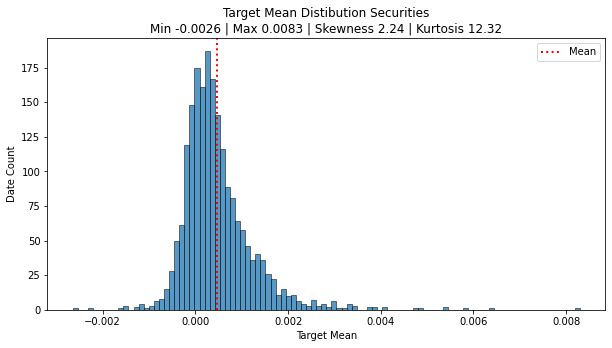

In [188]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=mean_securities_df.values, bins=100,
             ax=ax)
ax.axvline(x=total_mean_securities, color='red', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution Securities\n"
             f"Min {round(mean_securities_df.min(), 4)} | "
             f"Max {round(mean_securities_df.max(), 4)} | "
             f"Skewness {round(mean_securities_df.skew(), 2)} | "
             f"Kurtosis {round(mean_securities_df.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

In [189]:
mean_date_df = df_prices.groupby(["Date"])["Target"].mean()
total_mean_date = mean_date_df.mean()
total_mean_date

0.00044572606297777287

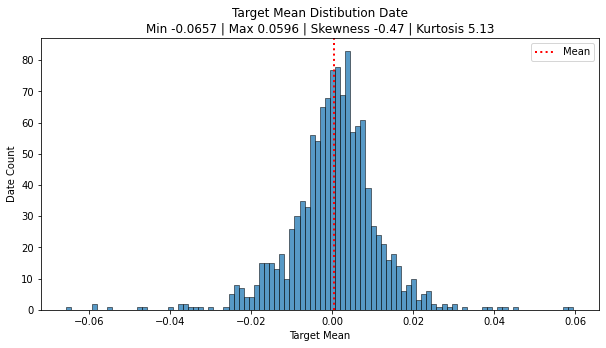

In [190]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=mean_date_df.values, bins=100,
             ax=ax)
ax.axvline(x=total_mean_date, color='red', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution Date\n"
             f"Min {round(mean_date_df.min(), 4)} | "
             f"Max {round(mean_date_df.max(), 4)} | "
             f"Skewness {round(mean_date_df.skew(), 2)} | "
             f"Kurtosis {round(mean_date_df.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

## Add correlation maps: between different securities, sectors

In [191]:
### ADD CORRELATION MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP

### Target vs Sector33

In [192]:
target_sector = df_prices.groupby(["33SectorName"])["Target"].mean()
target_sector.sort_values(inplace=True, ascending=False)


In [193]:
target_sector = target_sector.to_frame()
target_sector.reset_index(inplace= True)

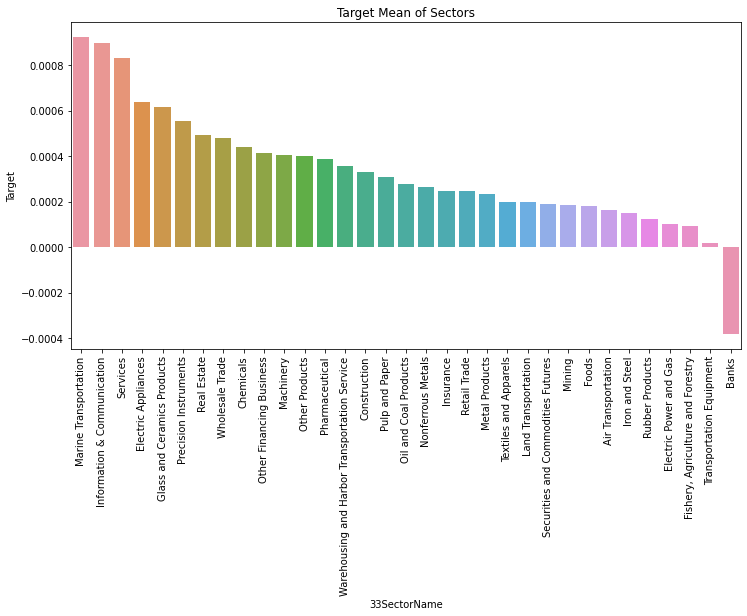

In [194]:
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x = "33SectorName", y = "Target", data = target_sector, ax=ax)
ax.set_title("Target Mean of Sectors")
ax.tick_params(axis='x', rotation=90)

### Target vs Section

In [195]:
target_section = df_prices.groupby(["Section/Products"])["Target"].mean()
target_section.sort_values(inplace=True, ascending=False)


In [196]:
target_section = target_section.to_frame()
target_section.reset_index(inplace= True)

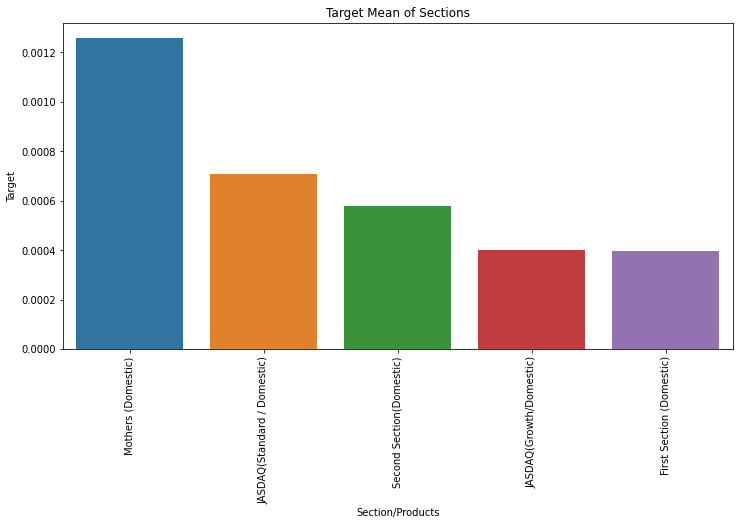

In [197]:
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x = "Section/Products", y = "Target", data = target_section, ax=ax)
ax.set_title("Target Mean of Sections")
ax.tick_params(axis='x', rotation=90)

### Secondary stock prices

Securities with low liquidity (few opportunities to trade)

In [198]:
display(secondary_stock_prices_df.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1305,2017-01-04,1305,1594.0,1618.0,1594.0,1615.0,538190,1.0,NaN,False,-0.001855
1,20170104_1306,2017-01-04,1306,1575.0,1595.0,1573.0,1593.0,2494980,1.0,NaN,False,-0.000627
2,20170104_1308,2017-01-04,1308,1557.0,1580.0,1557.0,1578.0,526100,1.0,NaN,False,-0.001900
3,20170104_1309,2017-01-04,1309,28810.0,29000.0,28520.0,28780.0,403,1.0,NaN,False,0.005237
4,20170104_1311,2017-01-04,1311,717.0,735.0,717.0,734.0,5470,1.0,NaN,False,0.001359


In [199]:
secondary_stock_prices_df.shape

(2384575, 12)

In [200]:
secondary_stock_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2384575 entries, 0 to 2384574
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 202.4+ MB


In [201]:
display(pd.isna(secondary_stock_prices_df).sum()/len(secondary_stock_prices_df)*100)

RowId                0.000000
Date                 0.000000
SecuritiesCode       0.000000
Open                 3.847688
High                 3.847688
Low                  3.847688
Close                3.847688
Volume               0.000000
AdjustmentFactor     0.000000
ExpectedDividend    99.225942
SupervisionFlag      0.000000
Target               0.030110
dtype: float64

**Missing values**

In [202]:
missing_secondary_high = secondary_stock_prices_df[secondary_stock_prices_df["High"].isna()]
display(missing_secondary_high.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
68,20170104_1468,2017-01-04,1468,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000
83,20170104_1484,2017-01-04,1484,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
86,20170104_1487,2017-01-04,1487,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
118,20170104_1584,2017-01-04,1584,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000
136,20170104_1623,2017-01-04,1623,NaN,NaN,NaN,NaN,0,1.0,NaN,False,-0.022126


In [203]:
missing_secondary_high["Date"].nunique()

1202

In [204]:
plot_missing_secondary_high_df = missing_secondary_high["Date"].value_counts().to_frame().reset_index()
plot_missing_secondary_high_df.rename(columns = {'index':'Date', 'Date':'Count'}, inplace = True)
plot_missing_secondary_high_df.head()

,Date,Count
0,2020-10-01,2009
1,2019-05-22,142
2,2019-08-08,141
3,2019-03-06,141
4,2019-08-29,140


As happened with the primary stock list 2020-10-01 is the day with the most amount of missing data


## Trades

Aggregated summary of trading volumes from the previous business week. Following is column information recorded in trades_spec.csv:

    Date: Data published date, usually Thursday on the following week.
    StartDate: The first trading date in this trading week.
    EndDate: The last trading date in this trading week.
    Section: Market division name.

In [205]:
display(trades_df.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


### Financials 

In [206]:
financials_df.head()

,DisclosureNumber,DateCode,Date,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,CurrentFiscalYearStartDate,CurrentFiscalYearEndDate,NetSales,OperatingProfit,OrdinaryProfit,Profit,EarningsPerShare,TotalAssets,Equity,EquityToAssetRatio,BookValuePerShare,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareFiscalYearEnd,ResultDividendPerShareAnnual,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,ForecastNetSales,ForecastOperatingProfit,ForecastOrdinaryProfit,ForecastProfit,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2.016121e+13,20170104_2753,2017-01-04,2753.0,2017-01-04,07:30:00,1.483483e+09,3QFinancialStatements_Consolidated_JP,2016-12-31,3Q,2016-04-01,2017-03-31,22761000000,2147000000,2234000000,1494000000,218.23,22386000000.0,18295000000.0,0.817,2671.42,－,50.0,－,NaN,NaN,NaN,NaN,NaN,50.0,100.0,31800000000,3255000000,3300000000,2190000000,319.76,NaN,False,True,False,False,False,6848800.0,－,6848800.0
1,2.017010e+13,20170104_3353,2017-01-04,3353.0,2017-01-04,15:00:00,1.483510e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,2016-03-01,2017-02-28,22128000000,820000000,778000000,629000000,328.57,25100000000.0,7566000000.0,0.301,NaN,－,36.0,－,NaN,NaN,NaN,NaN,NaN,36.0,72.0,30200000000,1350000000,1300000000,930000000,485.36,NaN,False,True,False,False,False,2035000.0,118917,1916083.0
2,2.016123e+13,20170104_4575,2017-01-04,4575.0,2017-01-04,12:00:00,1.483499e+09,ForecastRevision,2016-12-31,2Q,2016-07-01,2017-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110000000,-465000000,-466000000,-467000000,-93.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.017010e+13,20170105_2659,2017-01-05,2659.0,2017-01-05,15:00:00,1.483596e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,2016-03-01,2017-02-28,134781000000,11248000000,11558000000,7171000000,224.35,128464000000.0,100905000000.0,0.765,3073.12,－,0.0,－,NaN,NaN,NaN,NaN,NaN,42.0,42.0,177683000000,14168000000,14473000000,9111000000,285.05,NaN,False,True,False,False,False,31981654.0,18257,31963405.0
4,2.017011e+13,20170105_3050,2017-01-05,3050.0,2017-01-05,15:30:00,1.483598e+09,ForecastRevision,2017-02-28,FY,2016-02-29,2017-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,－,－,13.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
financials_df.shape

(92956, 45)

In [208]:
financials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92956 entries, 0 to 92955
Data columns (total 45 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   DisclosureNumber                                                              92954 non-null  float64
 1   DateCode                                                                      92954 non-null  object 
 2   Date                                                                          92956 non-null  object 
 3   SecuritiesCode                                                                92954 non-null  float64
 4   DisclosedDate                                                                 92954 non-null  object 
 5   DisclosedTime                                                                 92954 non-null  object 
 6   DisclosedUnixTime             

In [209]:
display(pd.isna(financials_df).sum()/len(financials_df)*100)

DisclosureNumber                                                                 0.002152
DateCode                                                                         0.002152
Date                                                                             0.000000
SecuritiesCode                                                                   0.002152
DisclosedDate                                                                    0.002152
DisclosedTime                                                                    0.002152
DisclosedUnixTime                                                                0.002152
TypeOfDocument                                                                   0.002152
CurrentPeriodEndDate                                                             0.002152
TypeOfCurrentPeriod                                                              0.002152
CurrentFiscalYearStartDate                                                       0.002152
CurrentFis

Super interesting for the stock price prediction but most of the data is missing...

### Options

**File Description**

Data on the status of a variety of options based on the broader market. Many options include implicit predictions of the future price of the stock market and so may be of interest even though the options are not scored directly. Following is column information recorded in options_spec.csv:

    DateCode: Unique ID for option price records, the combintion of Date and OptionCode.
    Date: Trade date and time.
    OptionsCode: Local securities code. Detailed information is provided in Identification Code Specifications for Futures and Options Transactionssakimono20220208-e.pdf).
    WholeDayOpen: Opening price for whole trading day.
    WholeDayHigh: Highest price for whole trading day.
    WholeDayLow: Lowest price for whole trading day.
    WholeDayClose: Closing price for whole trading day.
    NightSessionOpen: Opening price for night session.
    NightSessionHigh: Highest price for night session.
    NightSessionLow: Lowest price for night session.
    NightSessionClose: Closing price for night session.
    DaySessionOpen: Opening price for day session.
    DaySessionHigh: Highest price for day session.
    DaySessionLow: Lowest price for day session.
    DaySessionClose: Closing price for day session.
    TradingVolume: Trading volume of the product/contract for the whole trading day.
    OpenInterest: Open interest of the product/contract for the whole trading day
    TradingValue: Trading value of the product/contract for the whole trading day
    ContractMonth: Cotract year-month of the product/contract.
    StrikePrice: Exercise price of product/contract.
    DaySessionVolume: Trading volume of the product/contract for day session.
    Putcall: 1 for put and 2 for call.
    LastTradingDay: Last trading day.
    SpecialQuotationDay: The day when the Special Quotation is calculated.
    SettlementPrice: Settlement price.
    TheoreticalPrice: The theoretical price at the end of a day session.
    BaseVolatility: The volatility at the time of calculating the settlement price.
    ImpliedVolatility: Implied volatility.
    InterestRate: Interest rate for calculation.
    DividendRate: Dividend yeild.
    Dividend: Devidend.

In [210]:
options_df.head()

,DateCode,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,NightSessionClose,DaySessionOpen,DaySessionHigh,DaySessionLow,DaySessionClose,TradingVolume,OpenInterest,TradingValue,ContractMonth,StrikePrice,WholeDayVolume,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
0,20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0000,0.0000,0.0000,0.0000,650.0,650.0,480.0,480.0,6,19,3455000,201701,20000.0,6,1,20170112,20170113,480.0,478.4587,17.4736,17.5865,0.0091,0.0,0.0
1,20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,1,0,201701,20125.0,0,1,20170112,20170113,575.0,571.1385,17.4736,16.5000,0.0091,0.0,0.0
2,20170104_132010218,2017-01-04,132010218,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,5,0,201701,20250.0,0,1,20170112,20170113,680.0,677.3710,17.4736,15.8644,0.0091,0.0,0.0
3,20170104_132010318,2017-01-04,132010318,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,1,0,201701,20375.0,0,1,20170112,20170113,795.0,791.0383,17.4736,15.2288,0.0091,0.0,0.0
4,20170104_132010518,2017-01-04,132010518,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,0,0,201701,20500.0,0,1,20170112,20170113,910.0,909.9947,17.4736,14.5932,0.0091,0.0,0.0


In [211]:
options_df.shape

(3567694, 31)

In [212]:
options_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3567694 entries, 0 to 3567693
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   DateCode             object 
 1   Date                 object 
 2   OptionsCode          int64  
 3   WholeDayOpen         float64
 4   WholeDayHigh         float64
 5   WholeDayLow          float64
 6   WholeDayClose        float64
 7   NightSessionOpen     object 
 8   NightSessionHigh     object 
 9   NightSessionLow      object 
 10  NightSessionClose    object 
 11  DaySessionOpen       float64
 12  DaySessionHigh       float64
 13  DaySessionLow        float64
 14  DaySessionClose      float64
 15  TradingVolume        int64  
 16  OpenInterest         int64  
 17  TradingValue         int64  
 18  ContractMonth        int64  
 19  StrikePrice          float64
 20  WholeDayVolume       int64  
 21  Putcall              int64  
 22  LastTradingDay       int64  
 23  SpecialQuotationDay  int64  
 24

## 2. Cleaning data
- Input missing days
- Adjust price (Split- Reverse/split)
- Standarize values?


#### Generate Adjusted Close price
AdjustedClose using AdjustmentFactor value. This should reduce historical price gap caused by split/reverse-split.

In [11]:
df_prices_adj = adjust_price(df_prices)
df_prices_adj.head(5)

,RowId,Date,SecuritiesCode,Volume,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow
0,20170104_1301,2017-01-04,1301,31400,NaN,False,0.000730,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2742.0,2734.0,2755.0,2730.0
1,20170105_1301,2017-01-05,1301,17900,NaN,False,0.002920,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2738.0,2743.0,2747.0,2735.0
2,20170106_1301,2017-01-06,1301,19900,NaN,False,-0.001092,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2740.0,2734.0,2744.0,2720.0
3,20170110_1301,2017-01-10,1301,24200,NaN,False,-0.005100,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2748.0,2745.0,2754.0,2735.0
4,20170111_1301,2017-01-11,1301,9300,NaN,False,-0.003295,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2745.0,2748.0,2752.0,2737.0


In [19]:
del df_prices
gc.collect()

860

In [50]:
df_prices_adj["CumulativeAdjustmentFactor"].value_counts()

1.000000     2063087
0.500000      123655
0.250000       31860
5.000000       30099
10.000000      25106
0.333333       21582
2.000000        9677
0.200000        8056
0.125000        2162
0.166667        1829
0.909091        1643
0.666667        1642
0.833333        1294
0.769231        1094
0.100000        1079
0.952381         865
0.591716         768
0.062500         709
20.000000        669
4.000000         606
2.500000         600
0.641026         496
0.111111         410
3.333333         365
0.400000         327
0.040000         282
0.757576         246
0.761905         246
0.683013         245
0.751315         244
0.454545         244
0.826446         242
0.055556         198
0.869565         182
0.128205         173
0.083333         161
0.142857         106
0.692641          98
0.384615          90
0.620921          58
0.631313          36
Name: CumulativeAdjustmentFactor, dtype: int64

In [54]:
df_prices_adj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 23 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   RowId                       object        
 1   Date                        datetime64[ns]
 2   SecuritiesCode              int64         
 3   Volume                      int64         
 4   ExpectedDividend            float64       
 5   SupervisionFlag             bool          
 6   Target                      float64       
 7   Name                        object        
 8   Section/Products            object        
 9   NewMarketSegment            object        
 10  33SectorCode                object        
 11  33SectorName                object        
 12  17SectorCode                object        
 13  17SectorName                object        
 14  NewIndexSeriesSizeCode      object        
 15  NewIndexSeriesSize          object        
 16  IssuedShares      

**Less missing values**

In [216]:
display(pd.isna(df_prices_adj).sum()/len(df_prices_adj)*100)

RowId                          0.000000
Date                           0.000000
SecuritiesCode                 0.000000
Open                           0.326169
High                           0.326169
Low                            0.326169
Close                          0.326169
Volume                         0.000000
AdjustmentFactor               0.000000
ExpectedDividend              99.191222
SupervisionFlag                0.000000
Target                         0.010204
Name                           0.000000
Section/Products               0.000000
NewMarketSegment               0.000000
33SectorCode                   0.000000
33SectorName                   0.000000
17SectorCode                   0.000000
17SectorName                   0.000000
NewIndexSeriesSizeCode         0.000000
NewIndexSeriesSize             0.000000
IssuedShares                   0.000000
MarketCapitalization           0.000000
CumulativeAdjustmentFactor     0.000000
AdjustedClose                  0.000429


**Now the OHTC chart shows continuity**

In [217]:
plot_candle_with_target(df_prices, 9726, prime=True) 

In [218]:
plot_candle_with_target_adjusted(adjust_price(df_prices), 9726, prime=True) 

In [219]:
plot_candle_with_target(df_prices, 4582, prime=True)

In [220]:
plot_candle_with_target_adjusted(adjust_price(df_prices), 4582, prime=True) 

In [221]:
plot_candle_with_target(df_prices, 1805, prime=True)

In [222]:
plot_candle_with_target_adjusted(adjust_price(df_prices), 1805, prime=True) 

## 3. Feature Engineering
- Create basic statics
    1. Moving average
    2. Exponential moving average
    3. volatility
- Do not create Features since you are going to be using RNN
- Merge sentiment analysis data from Options
    1. https://www.boerse-stuttgart.de/de-de/tools/euwax-sentiment/
    2. https://www-mmds.sigmath.es.osaka-u.ac.jp/en/activity/vxj.php#:~:text=The%20Volatility%20Index%20Japan%20(VXJ,based%20on%20Nikkei225%20index%20options.
- Check correlation secondary stock market target vs Primary stock market target


**Correlogram to see if there is any autocorrelation**

In [22]:
df_9726 =df_prices_adj[df_prices_adj["SecuritiesCode"]==9726]

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

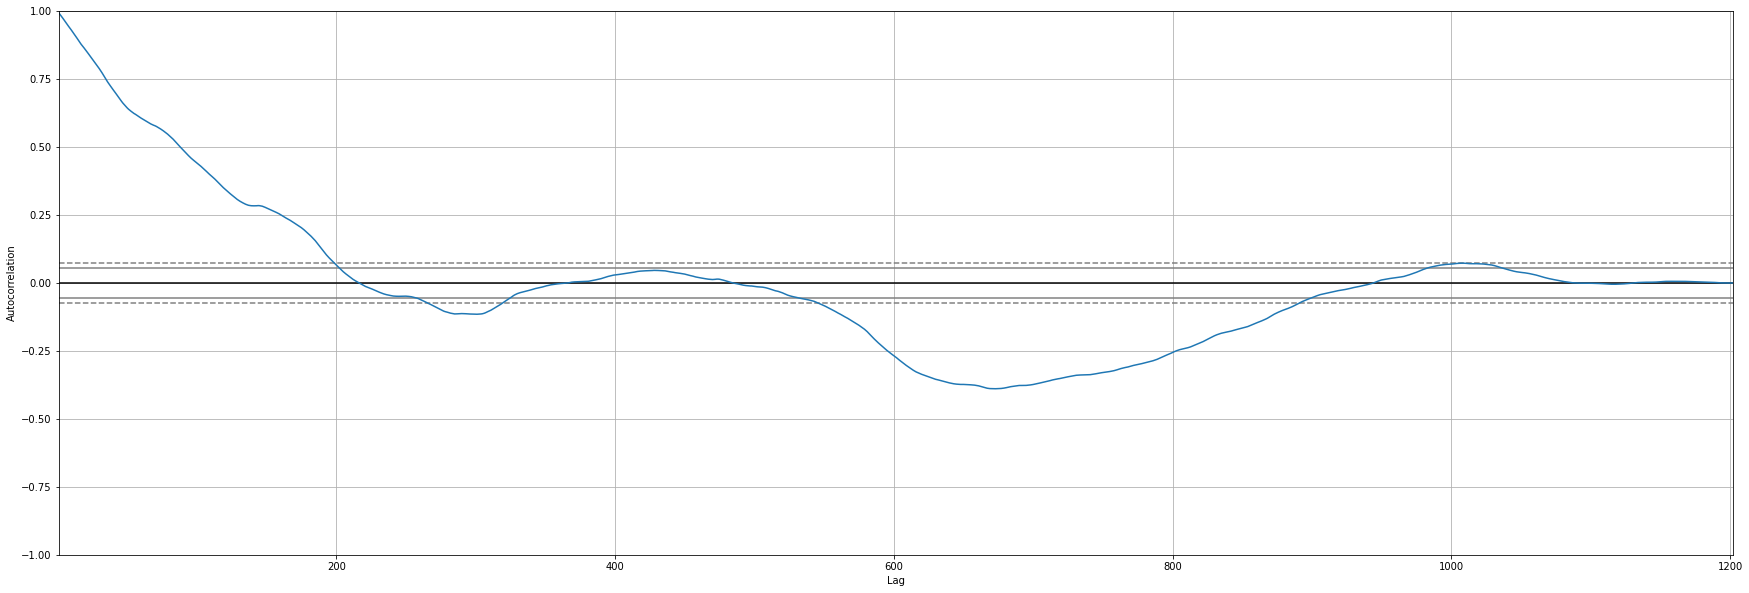

In [224]:
pd.plotting.autocorrelation_plot(df_9726["AdjustedClose"])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

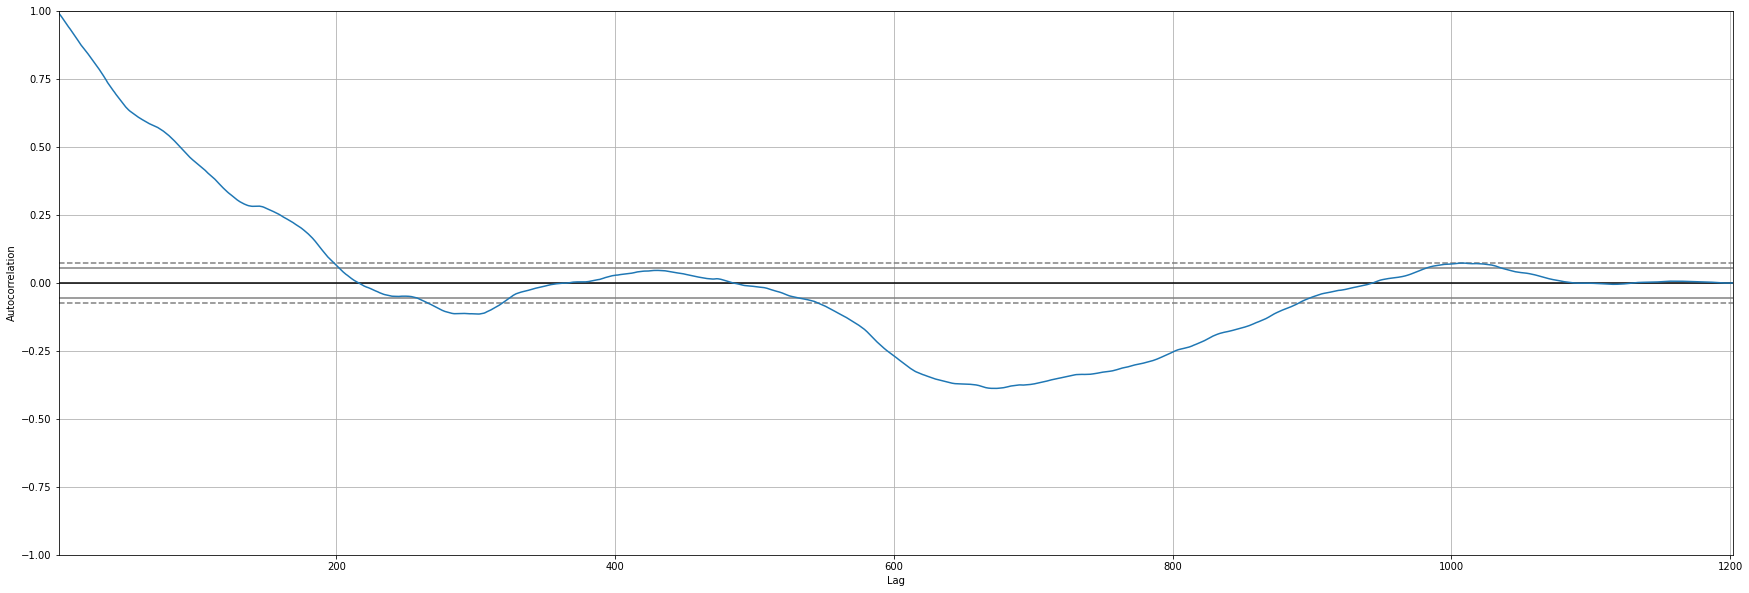

In [225]:
pd.plotting.autocorrelation_plot(df_9726["AdjustedOpen"])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

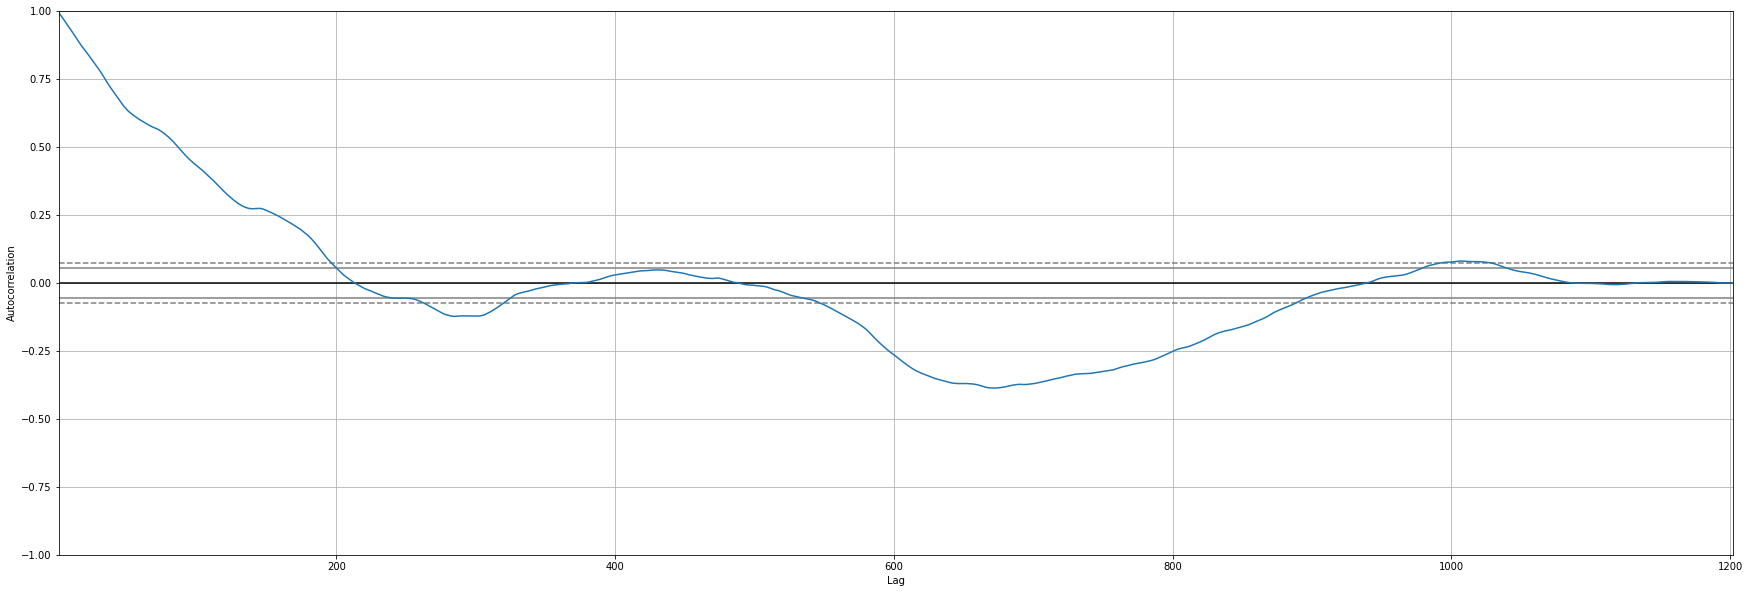

In [226]:
pd.plotting.autocorrelation_plot(df_9726["AdjustedHigh"])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

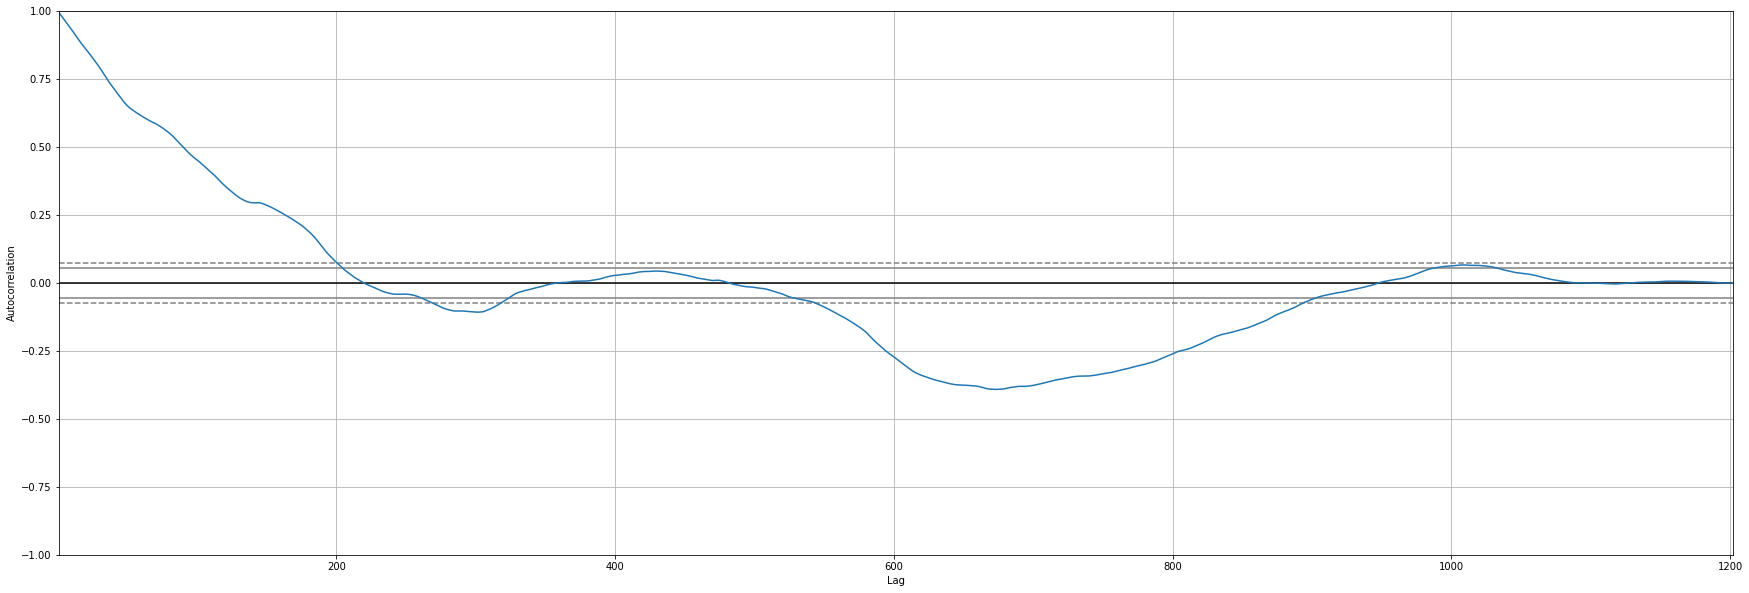

In [227]:
pd.plotting.autocorrelation_plot(df_9726["AdjustedLow"])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

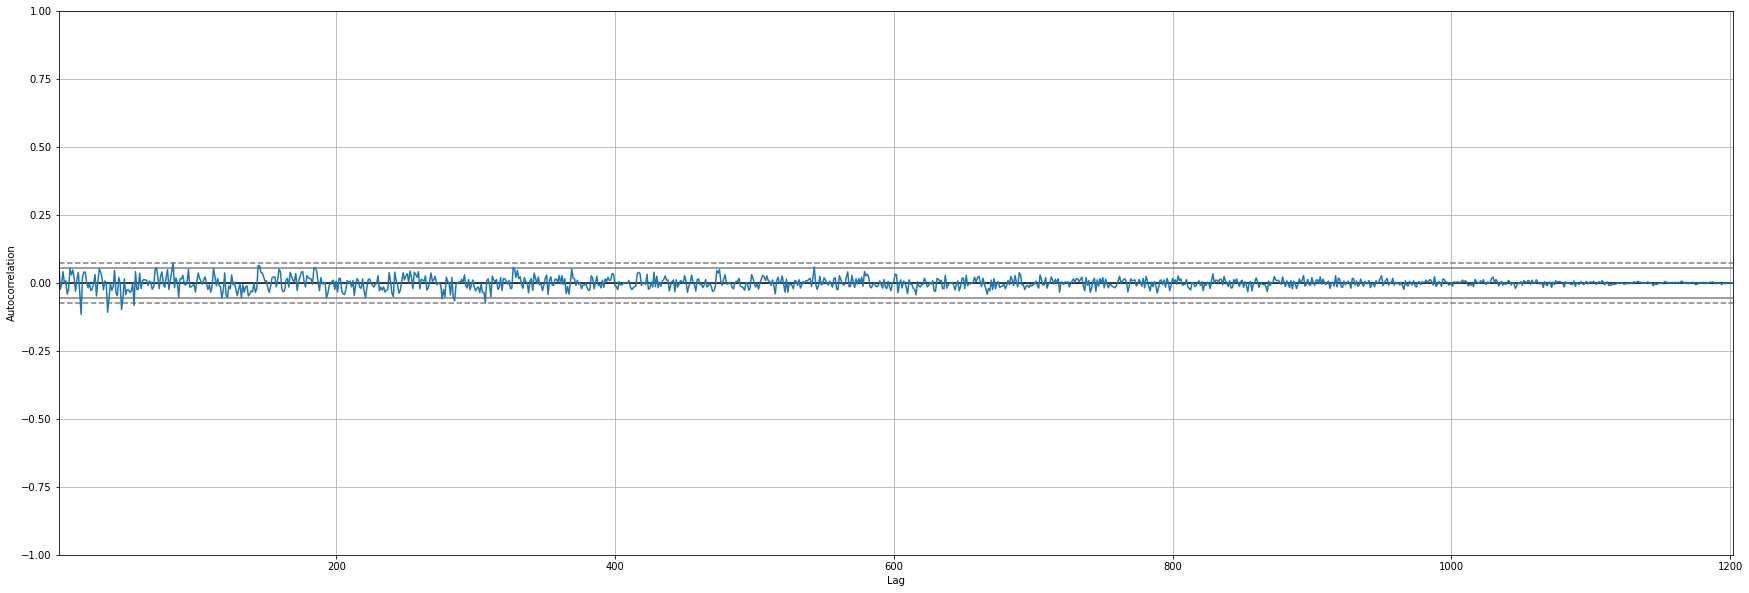

In [228]:
pd.plotting.autocorrelation_plot(df_9726["Target"])

It certainly look like we are dealing with a random walk, as there are no indications of any autocorrelation for any lag.

Basically our LSTM found nothing of any real value to model and thus took the average value, along with a slight slope; we would have been just as well off with an extremely simplistic model of the form

C
l
o
s
e
t
∝
C
l
o
s
e
(
t
−
1
)

Price is correlated but price change shows no correlation. Therefore, the target variable itself will not give us much info about future stock movements... We need a good Feature engineering

### Feature Engineering

**From adjusted prices (individual)**
- Price changes
- Moving average
- Exponential moving average
- Volumen
- Volatility
- RSI: Low, Medium, High

**From adjusted prices (GroupBy sector?)**

**Price changes**


In [229]:
period = [5,10,21,33]

In [230]:
for i in period:
    df_9726[f"pct{i}"] = df_9726["AdjustedClose"].pct_change(i)
display(df_9726.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,pct5,pct10,pct21,pct33
2245987,20170104_9726,2017-01-04,9726,146.0,148.0,145.0,147.0,472000,1.0,NaN,False,0.013605,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,10.0,1470.0,1460.0,1480.0,1450.0,NaN,NaN,NaN,NaN
2245988,20170105_9726,2017-01-05,9726,148.0,149.0,147.0,147.0,420000,1.0,NaN,False,0.020134,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,10.0,1470.0,1480.0,1490.0,1470.0,NaN,NaN,NaN,NaN
2245989,20170106_9726,2017-01-06,9726,147.0,149.0,147.0,149.0,462000,1.0,NaN,False,-0.006579,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,10.0,1490.0,1470.0,1490.0,1470.0,NaN,NaN,NaN,NaN
2245990,20170110_9726,2017-01-10,9726,150.0,153.0,149.0,152.0,1170000,1.0,NaN,False,-0.006623,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,10.0,1520.0,1500.0,1530.0,1490.0,NaN,NaN,NaN,NaN
2245991,20170111_9726,2017-01-11,9726,153.0,153.0,149.0,151.0,797000,1.0,NaN,False,0.006667,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,10.0,1510.0,1530.0,1530.0,1490.0,NaN,NaN,NaN,NaN


**Simple Moving Average (SMA)**

In [27]:
period_avg = [10,20,50,60]

In [28]:
for i in period_avg:
    df_9726[f"SMA_{i}"] = df_9726['AdjustedClose'].rolling(window=i).mean()

display(df_9726.tail(5))

,RowId,Date,SecuritiesCode,Volume,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,SMA_10,SMA_20,SMA_50,SMA_60
2247184,20211129_9726,2021-11-29,9726,220200,NaN,False,-0.002833,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1405.0,1447.0,1473.0,1403.0,1653.9,1694.80,1671.82,1623.783333
2247185,20211130_9726,2021-11-30,9726,146700,NaN,False,-0.086648,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1412.0,1444.0,1478.0,1407.0,1617.0,1681.70,1672.02,1624.983333
2247186,20211201_9726,2021-12-01,9726,77400,NaN,False,0.095645,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1408.0,1401.0,1429.0,1382.0,1575.5,1668.95,1672.06,1626.200000
2247187,20211202_9726,2021-12-02,9726,273800,NaN,False,0.022001,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1286.0,1228.0,1318.0,1228.0,1527.1,1645.90,1670.62,1625.366667
2247188,20211203_9726,2021-12-03,9726,141500,NaN,False,0.044444,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1409.0,1316.0,1409.0,1316.0,1493.2,1629.85,1670.62,1626.033333


**Exponential Moving Average (EMA)**

In [29]:
for i in period_avg:
    df_9726[f"EMA_{i}"] = df_9726['AdjustedClose'].ewm(span=i,adjust=False).mean()

display(df_9726.tail(5))

,RowId,Date,SecuritiesCode,Volume,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,SMA_10,SMA_20,SMA_50,SMA_60,EMA_10,EMA_20,EMA_50,EMA_60
2247184,20211129_9726,2021-11-29,9726,220200,NaN,False,-0.002833,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1405.0,1447.0,1473.0,1403.0,1653.9,1694.80,1671.82,1623.783333,1606.162071,1652.448618,1627.698192,1607.672109
2247185,20211130_9726,2021-11-30,9726,146700,NaN,False,-0.086648,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1412.0,1444.0,1478.0,1407.0,1617.0,1681.70,1672.02,1624.983333,1570.859876,1629.548750,1619.239439,1601.256630
2247186,20211201_9726,2021-12-01,9726,77400,NaN,False,0.095645,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1408.0,1401.0,1429.0,1382.0,1575.5,1668.95,1672.06,1626.200000,1541.248989,1608.448869,1610.955539,1594.920347
2247187,20211202_9726,2021-12-02,9726,273800,NaN,False,0.022001,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1286.0,1228.0,1318.0,1228.0,1527.1,1645.90,1670.62,1625.366667,1494.840082,1577.739453,1598.212185,1584.791812
2247188,20211203_9726,2021-12-03,9726,141500,NaN,False,0.044444,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1409.0,1316.0,1409.0,1316.0,1493.2,1629.85,1670.62,1626.033333,1479.232795,1561.669029,1590.792099,1579.028146


Plotting the new features

In [31]:
col_avg = ["AdjustedClose","SMA_10","SMA_20","SMA_50","SMA_60","EMA_10","EMA_20","EMA_20","EMA_60"]

In [33]:
df_9726Avg = df_9726[col_avg]
df_9726Avg.head()

,AdjustedClose,SMA_10,SMA_20,SMA_50,SMA_60,EMA_10,EMA_20,EMA_20,EMA_60
2245987,1470.0,NaN,NaN,NaN,NaN,1470.000000,1470.000000,1470.000000,1470.000000
2245988,1470.0,NaN,NaN,NaN,NaN,1470.000000,1470.000000,1470.000000,1470.000000
2245989,1490.0,NaN,NaN,NaN,NaN,1473.636364,1471.904762,1471.904762,1470.655738
2245990,1520.0,NaN,NaN,NaN,NaN,1482.066116,1476.485261,1476.485261,1472.273582
2245991,1510.0,NaN,NaN,NaN,NaN,1487.145004,1479.677141,1479.677141,1473.510514


<AxesSubplot:title={'center':'Avg analysis for Security Code'}>

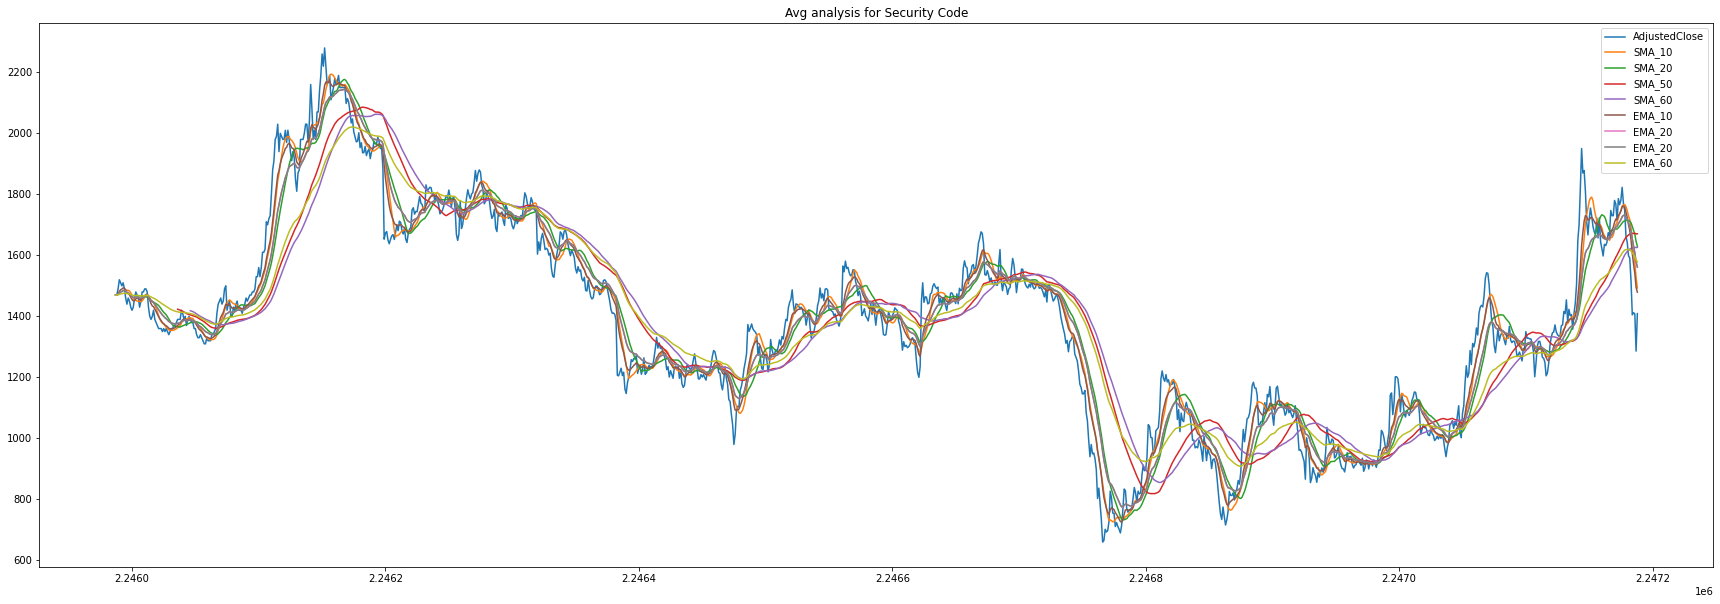

In [35]:
plt.rcParams["figure.figsize"] = (30,10)
df_9726Avg.plot(title = "Avg analysis for Security Code")

In [36]:
col_SMA = ["AdjustedClose","SMA_10","SMA_20","SMA_50","SMA_60"]

In [37]:
df_9726SMA = df_9726[col_SMA]
df_9726SMA.head()

,AdjustedClose,SMA_10,SMA_20,SMA_50,SMA_60
2245987,1470.0,NaN,NaN,NaN,NaN
2245988,1470.0,NaN,NaN,NaN,NaN
2245989,1490.0,NaN,NaN,NaN,NaN
2245990,1520.0,NaN,NaN,NaN,NaN
2245991,1510.0,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Avg analysis for Security Code'}>

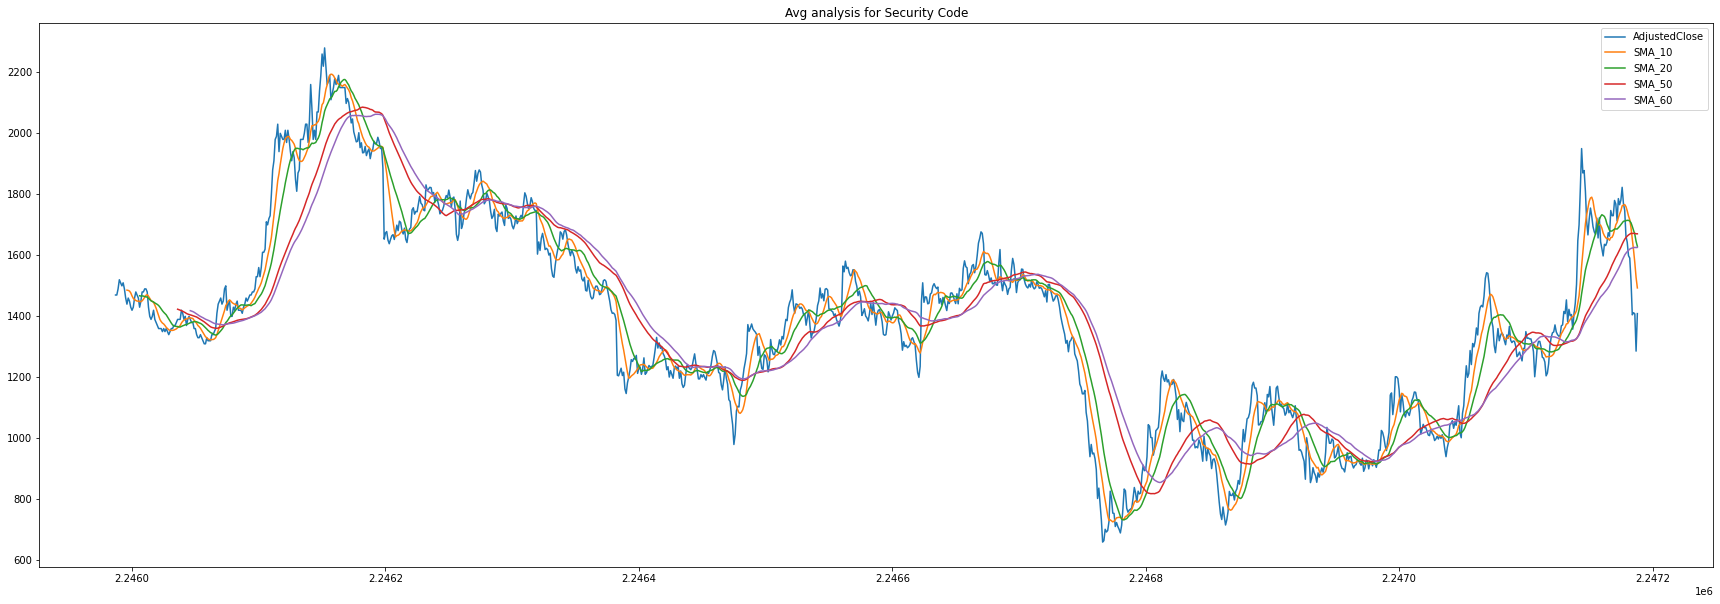

In [38]:
df_9726SMA.plot(title = "Avg analysis for Security Code")

In [39]:
col_EMA = ["AdjustedClose","EMA_10","EMA_20","EMA_50","EMA_60"]

In [40]:
df_9726EMA = df_9726[col_EMA]
df_9726EMA.head()

,AdjustedClose,EMA_10,EMA_20,EMA_50,EMA_60
2245987,1470.0,1470.000000,1470.000000,1470.000000,1470.000000
2245988,1470.0,1470.000000,1470.000000,1470.000000,1470.000000
2245989,1490.0,1473.636364,1471.904762,1470.784314,1470.655738
2245990,1520.0,1482.066116,1476.485261,1472.714341,1472.273582
2245991,1510.0,1487.145004,1479.677141,1474.176523,1473.510514


<AxesSubplot:title={'center':'Avg analysis for Security Code'}>

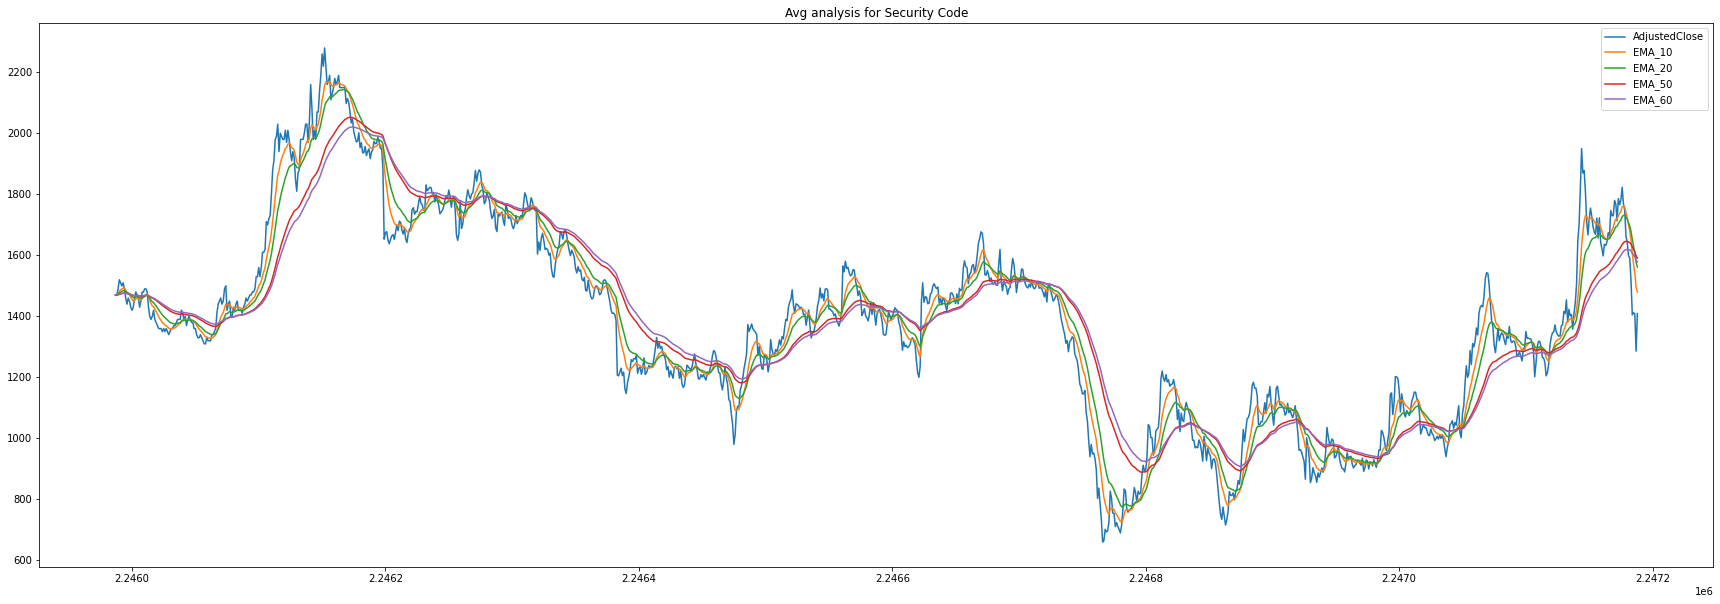

In [41]:
df_9726EMA.plot(title = "Avg analysis for Security Code")

In [12]:
def generate_feature(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime

    def generate_feature_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): Features for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        
        # generate PriceChanges
        period = [5,10,21,33]
        for i in period:
            df[f"pct{i}"] = df["AdjustedClose"].pct_change(i)
            df.loc[:, f"pct{i}"] = df.loc[:, f"pct{i}"].interpolate(method='linear',limit_direction='backward')
            df.loc[:,f"Volatility_{i}"] = np.log(df["AdjustedClose"]).diff().rolling(i).std()
            df.loc[:, f"Volatility_{i}"] = df.loc[:, f"Volatility_{i}"].interpolate(method='linear',limit_direction='backward')

        period_avg = [10,20,50,60]
        for i in period_avg:
         
            # generate SMA
            df[f"SMA_{i}"] = df['AdjustedClose'].rolling(window=i).mean()
            df.loc[:, f"SMA_{i}"] = df.loc[:, f"SMA_{i}"].interpolate(method='linear',limit_direction='backward')
          
            # generate EMA
            df[f"EMA_{i}"] = df['AdjustedClose'].ewm(span=i,adjust=False).mean()
            df.loc[:, f"EMA_{i}"] = df.loc[:, f"EMA_{i}"].interpolate(method='linear',limit_direction='backward')
        
        # reverse order
        df = df.sort_values("Date")

        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_feature_close).reset_index(drop=True)
    #price.set_index("Date", inplace=True)
    return price

In [13]:
df_prices_feat = generate_feature(df_prices_adj)
df_prices_feat.head(5)

,RowId,Date,SecuritiesCode,Volume,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,pct5,Volatility_5,pct10,Volatility_10,pct21,Volatility_21,pct33,Volatility_33,SMA_10,EMA_10,SMA_20,EMA_20,SMA_50,EMA_50,SMA_60,EMA_60
0,20170104_1301,2017-01-04,1301,31400,NaN,False,0.000730,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2742.0,2734.0,2755.0,2730.0,0.004028,0.002969,0.015932,0.003732,0.008088,0.004796,-0.048577,0.005294,2725.0,2733.158949,2725.75,2741.853831,2847.54,2815.764772,2891.566667,2838.160046
1,20170105_1301,2017-01-05,1301,17900,NaN,False,0.002920,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2738.0,2743.0,2747.0,2735.0,0.005878,0.003178,0.000365,0.006179,0.004771,0.004813,-0.064571,0.005795,2720.7,2731.194271,2725.10,2741.838444,2855.90,2818.775579,2894.800000,2841.419708
2,20170106_1301,2017-01-06,1301,19900,NaN,False,-0.001092,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2740.0,2734.0,2744.0,2720.0,0.013314,0.003734,0.007353,0.006468,0.003295,0.004838,-0.064208,0.005799,2720.6,2729.681887,2724.20,2742.242491,2865.04,2822.072541,2899.333333,2844.925461
3,20170110_1301,2017-01-10,1301,24200,NaN,False,-0.005100,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2748.0,2745.0,2754.0,2735.0,0.023083,0.002383,0.007701,0.006448,0.004019,0.004818,-0.066893,0.005834,2718.6,2727.388973,2723.45,2742.478543,2873.94,2825.422441,2903.833333,2848.482256
4,20170111_1301,2017-01-11,1301,9300,NaN,False,-0.003295,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2745.0,2748.0,2752.0,2737.0,0.018931,0.004005,0.005126,0.006484,0.002923,0.004813,-0.068228,0.005815,2716.5,2722.808745,2722.60,2741.897337,2881.98,2828.582540,2908.116667,2851.888435


In [76]:
del df_prices_adj
gc.collect()

23

**Feature engineering by Group**
- SectorCode33
- Section

In [245]:
for i in period_avg:
    df_prices_feat[f"Sector_SMA_{i}"] = df_prices_feat.groupby('33SectorCode').rolling(i)['AdjustedClose'].mean().reset_index(drop=True)
    df_prices_feat.loc[:, f"Sector_SMA_{i}"] = df_prices_feat.loc[:, f"Sector_SMA_{i}"].interpolate(method='linear',limit_direction='backward')

In [246]:
df_prices_feat.tail()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,pct5,pct10,pct21,pct33,SMA_10,SMA_20,SMA_50,SMA_90,EMA_10,EMA_20,EMA_50,EMA_90,Sector_SMA_10,Sector_SMA_20,Sector_SMA_50,Sector_SMA_90
2332526,20211129_9997,2021-11-29,9997,678.0,679.0,665.0,668.0,320800,1.0,NaN,False,0.026987,"BELLUNA CO.,LTD.",First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,6,TOPIX Small 1,97244472.0,6.894633e+10,1.0,668.0,678.0,679.0,665.0,-0.011494,0.028736,0.093391,0.196839,692.5,721.3,781.22,812.866667,684.061198,689.130455,692.993734,694.283286,1844.3,1844.00,1877.52,1829.488889
2332527,20211130_9997,2021-11-30,9997,670.0,689.0,667.0,667.0,296300,1.0,NaN,False,-0.001460,"BELLUNA CO.,LTD.",First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,6,TOPIX Small 1,97244472.0,6.894633e+10,1.0,667.0,670.0,689.0,667.0,-0.011494,0.028736,0.093391,0.196839,692.5,721.3,781.22,812.866667,687.630353,691.354713,694.013886,694.873922,1832.5,1843.95,1875.30,1830.177778
2332528,20211201_9997,2021-12-01,9997,661.0,688.0,660.0,685.0,339100,1.0,NaN,False,0.017544,"BELLUNA CO.,LTD.",First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,6,TOPIX Small 1,97244472.0,6.894633e+10,1.0,685.0,661.0,688.0,660.0,-0.011494,0.028736,0.093391,0.196839,692.5,721.3,781.22,812.866667,692.214876,693.918367,695.116494,695.500302,1817.3,1837.70,1872.68,1830.688889
2332529,20211202_9997,2021-12-02,9997,681.0,692.0,680.0,684.0,342900,1.0,NaN,False,0.014368,"BELLUNA CO.,LTD.",First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,6,TOPIX Small 1,97244472.0,6.894633e+10,1.0,684.0,681.0,692.0,680.0,-0.011494,0.028736,0.093391,0.196839,692.5,721.3,781.22,812.866667,693.818182,694.857143,695.529412,695.736264,1806.7,1832.65,1868.64,1831.022222
2332530,20211203_9997,2021-12-03,9997,690.0,711.0,686.0,696.0,381100,1.0,NaN,False,0.018414,"BELLUNA CO.,LTD.",First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,6,TOPIX Small 1,97244472.0,6.894633e+10,1.0,696.0,690.0,711.0,686.0,-0.011494,0.028736,0.093391,0.196839,692.5,721.3,781.22,812.866667,696.000000,696.000000,696.000000,696.000000,1801.2,1827.40,1866.52,1831.411111


In [247]:
col_Sector = ["AdjustedClose","Sector_SMA_10","Sector_SMA_20","Sector_SMA_50","Sector_SMA_90"]

In [248]:
df_1301_feat = df_prices_feat[df_prices_feat["SecuritiesCode"]==1301]

In [249]:
df_1301_feat = df_1301_feat[col_Sector]
df_1301_feat.head()

,AdjustedClose,Sector_SMA_10,Sector_SMA_20,Sector_SMA_50,Sector_SMA_90
0,2742.0,5578.0,5619.5,5761.6,5775.222222
1,2738.0,5578.0,5619.5,5761.6,5775.222222
2,2740.0,5578.0,5619.5,5761.6,5775.222222
3,2748.0,5578.0,5619.5,5761.6,5775.222222
4,2745.0,5578.0,5619.5,5761.6,5775.222222


<AxesSubplot:title={'center':'Avg analysis for Security Code'}>

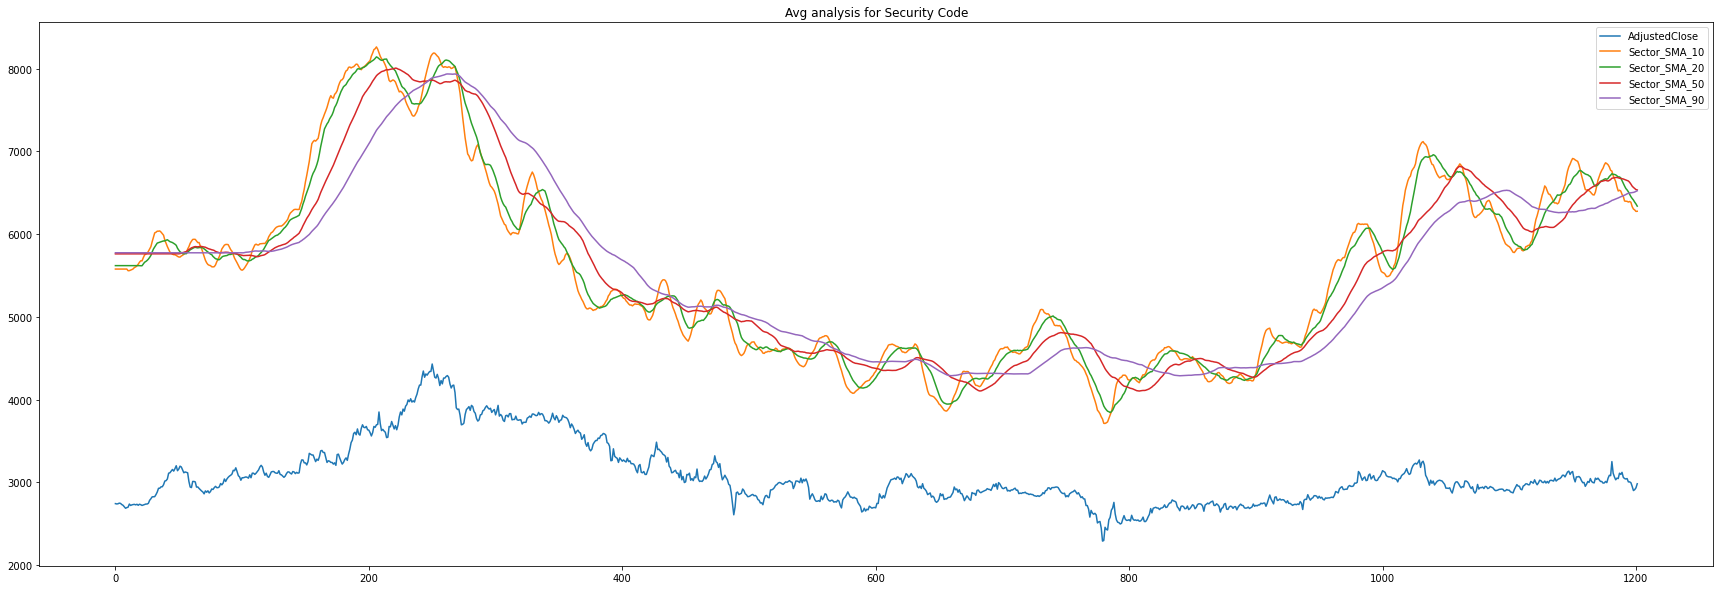

In [250]:
df_1301_feat.plot(title = "Avg analysis for Security Code")

**It seems to be a correlation between the total sector trend and security trend**

In [251]:
for i in period_avg:
    df_prices_feat[f"Sector_EMA_{i}"] = df_prices_feat.groupby('33SectorCode').ewm(span=i,adjust=False)['AdjustedClose'].mean().reset_index(drop=True)
    df_prices_feat.loc[:, f"Sector_EMA_{i}"] = df_prices_feat.loc[:, f"Sector_EMA_{i}"].interpolate(method='linear',limit_direction='backward')

In [252]:
df_prices_feat.head(5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,pct5,pct10,pct21,pct33,SMA_10,SMA_20,SMA_50,SMA_90,EMA_10,EMA_20,EMA_50,EMA_90,Sector_SMA_10,Sector_SMA_20,Sector_SMA_50,Sector_SMA_90,Sector_EMA_10,Sector_EMA_20,Sector_EMA_50,Sector_EMA_90
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2742.0,2734.0,2755.0,2730.0,0.004028,0.015932,0.008088,-0.048577,2725.0,2725.75,2847.54,2909.722222,2733.158949,2741.853831,2815.764772,2899.364697,5578.0,5619.5,5761.6,5775.222222,5720.000000,5720.000000,5720.000000,5720.000000
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2738.0,2743.0,2747.0,2735.0,0.005878,0.000365,0.004771,-0.064571,2720.7,2725.10,2855.90,2913.422222,2731.194271,2741.838444,2818.775579,2902.900983,5578.0,5619.5,5761.6,5775.222222,5709.090909,5714.285714,5717.647059,5718.681319
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2740.0,2734.0,2744.0,2720.0,0.013314,0.007353,0.003295,-0.064208,2720.6,2724.20,2865.04,2917.277778,2729.681887,2742.242491,2822.072541,2906.606623,5578.0,5619.5,5761.6,5775.222222,5672.892562,5694.829932,5709.504037,5714.094916
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2748.0,2745.0,2754.0,2735.0,0.023083,0.007701,0.004019,-0.066893,2718.6,2723.45,2873.94,2921.277778,2727.388973,2742.478543,2825.422441,2910.350592,5578.0,5619.5,5761.6,5775.222222,5643.275733,5677.227081,5701.680349,5709.609314
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2745.0,2748.0,2752.0,2737.0,0.018931,0.005126,0.002923,-0.068228,2716.5,2722.60,2881.98,2925.688889,2722.808745,2741.897337,2828.582540,2913.998920,5578.0,5619.5,5761.6,5775.222222,5648.134690,5676.538788,5700.437983,5708.738779


In [253]:
sec_array = df_prices_feat[df_prices_feat["33SectorCode"] == "50"]["SecuritiesCode"].unique()

In [254]:
sec_array


array([1301, 1332, 1333, 1375, 1376, 1377, 1379, 1381])

In [255]:
df_1301 = df_prices_feat[df_prices_feat["SecuritiesCode"] == 1301]
df_1301 = df_1301[col_Sector]
df_1301.head()

,AdjustedClose,Sector_SMA_10,Sector_SMA_20,Sector_SMA_50,Sector_SMA_90
0,2742.0,5578.0,5619.5,5761.6,5775.222222
1,2738.0,5578.0,5619.5,5761.6,5775.222222
2,2740.0,5578.0,5619.5,5761.6,5775.222222
3,2748.0,5578.0,5619.5,5761.6,5775.222222
4,2745.0,5578.0,5619.5,5761.6,5775.222222


<AxesSubplot:title={'center':'Avg analysis for Security Code'}>

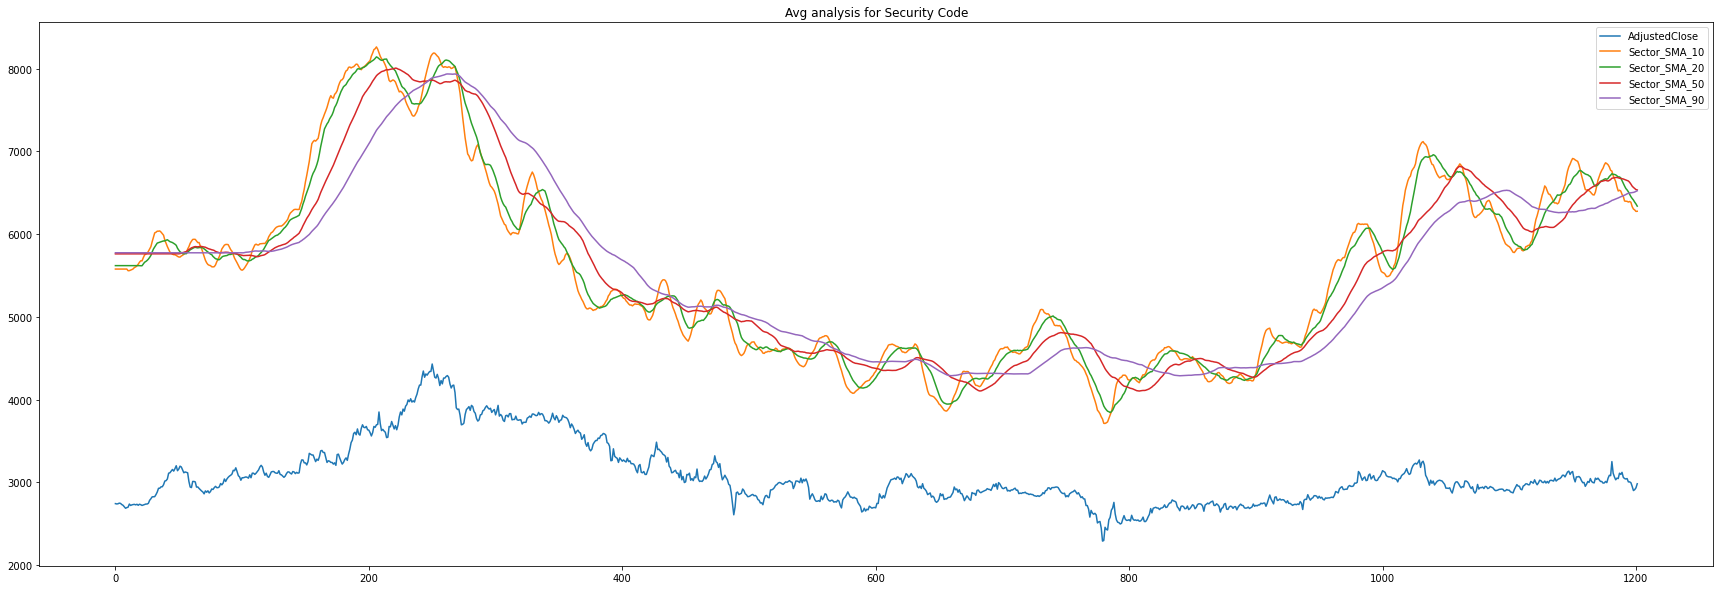

In [256]:
df_1301.plot(title = "Avg analysis for Security Code")

In [13]:
def generate_feature_group(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime

    def generate_feature_group_by(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): Features for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        
        # generate SMA SectorCode
        period_avg = [10,20,50,90]
        for i in period_avg:
            df[f"Sector_SMA_{i}"] = df.groupby('33SectorCode').rolling(i)['AdjustedClose'].mean().reset_index(drop=True)
            df.loc[:, f"Sector_SMA_{i}"] = df.loc[:, f"Sector_SMA_{i}"].interpolate(method='linear',limit_direction='backward')
            
        # generate EMA SectorCode
        for i in period_avg:
            df[f"Sector_EMA_{i}"] = df.groupby('33SectorCode').ewm(span=i,adjust=False)['AdjustedClose'].mean().reset_index(drop=True)
            df.loc[:, f"Sector_EMA_{i}"] = df.loc[:, f"Sector_EMA_{i}"].interpolate(method='linear',limit_direction='backward')
        
        # generate SMA Section/Products
        period_avg = [10,20,50,90]
        for i in period_avg:
            df[f"SectionProduct_SMA_{i}"] = df.groupby('Section/Products').rolling(i)['AdjustedClose'].mean().reset_index(drop=True)
            df.loc[:, f"SectionProduct_SMA_{i}"] = df.loc[:, f"SectionProduct_SMA_{i}"].interpolate(method='linear',limit_direction='backward')
            
        # generate EMA Section/Products
        for i in period_avg:
            df[f"SectionProduct_EMA_{i}"] = df.groupby('Section/Products').ewm(span=i,adjust=False)['AdjustedClose'].mean().reset_index(drop=True)
            df.loc[:, f"SectionProduct_EMA_{i}"] = df.loc[:, f"SectionProduct_EMA_{i}"].interpolate(method='linear',limit_direction='backward')
        
        # reverse order
        df = df.sort_values("Date")
        return df

    # generate AdjustedClose
    #price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_feature_group_by).reset_index(drop=True)
    #price = price.apply(generate_feature_group_by).reset_index(drop=True)
    #price.set_index("Date", inplace=True)
    return price

import sys
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

In [14]:
df_prices_feat_group = generate_feature_group(df_prices_feat)
df_prices_feat_group

,RowId,Date,SecuritiesCode,Volume,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,pct5,Volatility_5,pct10,Volatility_10,pct21,Volatility_21,pct33,Volatility_33,SMA_10,EMA_10,SMA_20,EMA_20,SMA_50,EMA_50,SMA_90,EMA_90,Sector_SMA_10,Sector_SMA_20,Sector_SMA_50,Sector_SMA_90,Sector_EMA_10,Sector_EMA_20,Sector_EMA_50,Sector_EMA_90,SectionProduct_SMA_10,SectionProduct_SMA_20,SectionProduct_SMA_50,SectionProduct_SMA_90,SectionProduct_EMA_10,SectionProduct_EMA_20,SectionProduct_EMA_50,SectionProduct_EMA_90
0,20170104_1301,2017-01-04,1301,31400,NaN,False,0.000730,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2742.0,2734.0,2755.0,2730.0,0.004028,0.002969,0.015932,0.003732,0.008088,0.004796,-0.048577,0.005294,2725.0,2733.158949,2725.75,2741.853831,2847.54,2815.764772,2909.722222,2899.364697,NaN,NaN,NaN,NaN,2982.000000,2982.000000,2982.000000,2982.000000,NaN,NaN,NaN,NaN,2982.000000,2982.000000,2982.000000,2982.000000
1,20170105_1301,2017-01-05,1301,17900,NaN,False,0.002920,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2738.0,2743.0,2747.0,2735.0,0.005878,0.003178,0.000365,0.006179,0.004771,0.004813,-0.064571,0.005795,2720.7,2731.194271,2725.10,2741.838444,2855.90,2818.775579,2913.422222,2902.900983,NaN,NaN,NaN,NaN,2973.090909,2977.333333,2980.078431,2980.923077,NaN,NaN,NaN,NaN,2973.090909,2977.333333,2980.078431,2980.923077
2,20170106_1301,2017-01-06,1301,19900,NaN,False,-0.001092,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2740.0,2734.0,2744.0,2720.0,0.013314,0.003734,0.007353,0.006468,0.003295,0.004838,-0.064208,0.005799,2720.6,2729.681887,2724.20,2742.242491,2865.04,2822.072541,2917.277778,2906.606623,NaN,NaN,NaN,NaN,2961.801653,2971.015873,2977.369473,2979.386306,NaN,NaN,NaN,NaN,2961.801653,2971.015873,2977.369473,2979.386306
3,20170110_1301,2017-01-10,1301,24200,NaN,False,-0.005100,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2748.0,2745.0,2754.0,2735.0,0.023083,0.002383,0.007701,0.006448,0.004019,0.004818,-0.066893,0.005834,2718.6,2727.388973,2723.45,2742.478543,2873.94,2825.422441,2921.277778,2910.350592,NaN,NaN,NaN,NaN,2950.564989,2964.252457,2974.335376,2977.641552,NaN,NaN,NaN,NaN,2950.564989,2964.252457,2974.335376,2977.641552
4,20170111_1301,2017-01-11,1301,9300,NaN,False,-0.003295,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2745.0,2748.0,2752.0,2737.0,0.018931,0.004005,0.005126,0.006484,0.002923,0.004813,-0.068228,0.005815,2716.5,2722.808745,2722.60,2741.897337,2881.98,2828.582540,2925.688889,2913.998920,NaN,NaN,NaN,NaN,2950.644082,2962.990318,2973.420263,2977.056023,NaN,NaN,NaN,NaN,2950.644082,2962.990318,2973.420263,2977.056023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211129_9997,2021-11-29,9997,320800,NaN,False,0.026987,"BELLUNA CO.,LTD.",First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,6,TOPIX Small 1,97244472.0,6.894633e+10,1.0,668.0,678.0,679.0,665.0,-0.011494,NaN,0.028736,NaN,0.093391,NaN,0.196839,NaN,692.5,684.061198,721.30,689.130455,781.22,692.993734,812.866667,694.283286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2332527,20211130_9997,2021-11-30

In [15]:

display(pd.isna(df_prices_feat_group).sum()/len(df_prices_feat_group)*100)

RowId                          0.000000
Date                           0.000000
SecuritiesCode                 0.000000
Volume                         0.000000
ExpectedDividend              99.191222
SupervisionFlag                0.000000
Target                         0.010204
Name                           0.000000
Section/Products               0.000000
NewMarketSegment               0.000000
33SectorCode                   0.000000
33SectorName                   0.000000
17SectorCode                   0.000000
17SectorName                   0.000000
NewIndexSeriesSizeCode         0.000000
NewIndexSeriesSize             0.000000
IssuedShares                   0.000000
MarketCapitalization           0.000000
CumulativeAdjustmentFactor     0.000000
AdjustedClose                  0.000429
AdjustedOpen                   0.000429
AdjustedHigh                   0.000429
AdjustedLow                    0.000429
pct5                           0.000000
Volatility_5                   0.429148


### 3. Prediction Model

In [14]:
X = df_prices_feat[["Date","SecuritiesCode","Target","Volume","AdjustedClose","pct5","pct10","pct21","pct33","Volatility_5","Volatility_10","Volatility_21","Volatility_33","SMA_10","SMA_20","SMA_50","SMA_60","EMA_10","EMA_20","EMA_50"]]
X=X.dropna().sort_values(['Date','SecuritiesCode'])


In [15]:
y= X["Target"].to_numpy()
X=X.drop(["Target"],axis=1)

### Time based Crossvalidation

In [16]:
params = {'n_estimators': 500,
          'num_leaves' : 100,
          'learning_rate': 0.1,
          'colsample_bytree': 0.9,
          'subsample': 0.8,
          'reg_alpha': 0.4,
          'metric': 'mae',
          'random_state': 21}

In [17]:
ts_fold = TimeSeriesSplit(n_splits=10, gap=10000)

In [18]:
feat_importance=pd.DataFrame()
sharpe_ratio=[]

In [19]:
for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X, y)):
    
    print(f"\n========================== Fold {fold+1} ==========================")
        
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_valid, y_val = X.iloc[val_idx,:], y[val_idx]
    
    print("Train Date range: {} to {}".format(X_train.Date.min(),X_train.Date.max()))
    print("Valid Date range: {} to {}".format(X_valid.Date.min(),X_valid.Date.max()))
    
    X_train.drop(['Date','SecuritiesCode'], axis=1, inplace=True)
    X_val=X_valid[X_valid.columns[~X_valid.columns.isin(['Date','SecuritiesCode'])]]
    val_dates=X_valid.Date.unique()[1:-1]
    print("\nTrain Shape: {} {}, Valid Shape: {} {}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))
    
    gbm = LGBMRegressor(**params).fit(X_train, y_train, 
                                      eval_set=[(X_train, y_train), (X_val, y_val)],
                                      verbose=300, 
                                      eval_metric=['mae','mse'])
    y_pred = gbm.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    feat_importance["Importance_Fold"+str(fold)]=gbm.feature_importances_
    feat_importance.set_index(X_train.columns, inplace=True)
        
    rank=[]
    X_val_df=X_valid[X_valid.Date.isin(val_dates)]
    for i in X_val_df.Date.unique():
        temp_df = X_val_df[X_val_df.Date == i].drop(['Date','SecuritiesCode'],axis=1)
        temp_df["pred"] = gbm.predict(temp_df)
        temp_df["Rank"] = (temp_df["pred"].rank(method="first", ascending=False)-1).astype(int)
        rank.append(temp_df["Rank"].values)

    stock_rank=pd.Series([x for y in rank for x in y], name="Rank")
    df=pd.concat([X_val_df.reset_index(drop=True),stock_rank,
                  df_prices_feat[df_prices_feat.Date.isin(val_dates)]['Target'].reset_index(drop=True)], axis=1)
    sharpe=calc_spread_return_sharpe(df)
    sharpe_ratio.append(sharpe)
    print("Valid Sharpe: {}, RMSE: {}, MAE: {}".format(sharpe,rmse,mae))
    
    #del X_train, y_train,  X_val, y_val
    gc.collect()
    
print("\nAverage cross-validation Sharpe Ratio: {:.4f}, standard deviation = {:.2f}.".format(np.mean(sharpe_ratio),np.std(sharpe_ratio)))


========================== Fold 1 ==========================
Train Date range: 2017-01-04 00:00:00 to 2017-06-12 00:00:00
Valid Date range: 2017-06-19 00:00:00 to 2017-12-01 00:00:00

Train Shape: (202033, 17) (202033,), Valid Shape: (212025, 17) (212025,)
[300]	training's l2: 0.000211362	training's l1: 0.0103421	valid_1's l2: 0.000299631	valid_1's l1: 0.0112376
Valid Sharpe: 0.0952270703928215, RMSE: 0.0173403734167969, MAE: 0.011241574753536406

========================== Fold 2 ==========================
Train Date range: 2017-01-04 00:00:00 to 2017-11-22 00:00:00
Valid Date range: 2017-12-01 00:00:00 to 2018-05-18 00:00:00

Train Shape: (414058, 17) (414058,), Valid Shape: (212025, 17) (212025,)
[300]	training's l2: 0.000231453	training's l1: 0.0105997	valid_1's l2: 0.00041184	valid_1's l1: 0.0135034
Valid Sharpe: 0.12334258464961927, RMSE: 0.020289684196062766, MAE: 0.01349099378409929

========================== Fold 3 ==========================
Train Date range: 2017-01-04 00:0

In [20]:
feat_importance['avg'] = feat_importance.mean(axis=1)
feat_importance = feat_importance.sort_values(by='avg',ascending=True)
pal=sns.color_palette("plasma_r", 29).as_hex()[2:]

fig=go.Figure()
for i in range(len(feat_importance.index)):
    fig.add_shape(dict(type="line", y0=i, y1=i, x0=0, x1=feat_importance['avg'][i], 
                       line_color=pal[::-1][i],opacity=0.7,line_width=4))
fig.add_trace(go.Scatter(x=feat_importance['avg'], y=feat_importance.index, mode='markers', 
                         marker_color=pal[::-1], marker_size=8,
                         hovertemplate='%{y} Importance = %{x:.0f}<extra></extra>'))
fig.update_layout(title='Overall Feature Importance', 
                  xaxis=dict(title='Average Importance',zeroline=False),
                  yaxis_showgrid=False, margin=dict(l=120,t=80),
                  height=700, width=800)
fig.show()

### 5.API Submission

In [21]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [22]:
cols=['Date','SecuritiesCode','Open','High','Low','Close','Volume','AdjustmentFactor']
stock_prices_df=stock_prices_df[stock_prices_df.Date>='2021-08-01'][cols]

cols_fin = ["Date","Volume","AdjustedClose","pct5","pct10","pct21","pct33","Volatility_5","Volatility_10","Volatility_21","Volatility_33","SMA_10","SMA_20","SMA_50","SMA_60","EMA_10","EMA_20","EMA_50"]

counter = 0
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    ## Loading API data and combine it with the dataset
    current_date = prices["Date"].iloc[0]
    if counter == 0:
        df_price_raw = stock_prices_df.loc[stock_prices_df["Date"] < current_date]
    
    df_price_raw = pd.concat([df_price_raw, prices[cols]]).reset_index(drop=True)
    
    ## Feature engineering
    df_price = adjust_price(df_price_raw)
    features = generate_feature(df_price)
    features = features[cols_fin]
    feat = features[features.Date == current_date].drop(['Date'],axis=1)
    
    ## Prediction using the Model
    feat["pred"] = gbm.predict(feat)
    
    ## Generate Ranking 0-1999
    feat["Rank"] = (feat["pred"].rank(method="first", ascending=False)-1).astype(int)
    
    ## Input the ranking to the submission file
    sample_prediction["Rank"] = feat["Rank"].values
    display(sample_prediction.head())
    
    ## Input the ranking to the submission file
    assert sample_prediction["Rank"].notna().all()
    assert sample_prediction["Rank"].min() == 0
    assert sample_prediction["Rank"].max() == len(sample_prediction["Rank"]) - 1
    
    ## Submitt prediction file
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,Date,SecuritiesCode,Rank
0,2021-12-06,1301,1159
1,2021-12-06,1332,294
2,2021-12-06,1333,217
3,2021-12-06,1375,1673
4,2021-12-06,1376,1690


,Date,SecuritiesCode,Rank
0,2021-12-07,1301,696
1,2021-12-07,1332,1945
2,2021-12-07,1333,859
3,2021-12-07,1375,1385
4,2021-12-07,1376,1295
